In [ ]:
pip install --upgrade pyDOE


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=9a9e04d7418afa79311af34e996466b0a1b95811fa29fb67df650606ca8e91f0
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


# Buidling the collocation points for the domain

In [ ]:
'''
@author: #SAMAN
'''
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs
N_f = 10000
Nu1 = 200


xmax=6.0
x1 = (np.linspace(0, xmax, 32)).flatten()[:, None]
y1 = (np.linspace(0, 1, 32)).flatten()[:, None]
t1 = (np.linspace(0, 1, 20)).flatten()[:, None]

ttt1, ttt0 = np.meshgrid(x1, y1)

tt1 = np.concatenate(([ttt1.flatten()[:, None], ttt0.flatten()[:, None], np.zeros((x1.shape[0] * y1.shape[0], 1))]), axis=1)
x_1t = np.array([tt1[:, 0]]).T
y_1t = np.array([tt1[:, 1]]).T
t_1t = np.array([tt1[:, 2]]).T
ut1 = -np.sin(t_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.cos(np.pi * y_1t)
vt1 = np.sin(t_1t) * np.sin(np.pi * x_1t) * np.cos(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.sin(np.pi * y_1t)

yyy1, yyy0 = np.meshgrid(x1, t1)

yy1 = np.concatenate(
    ([yyy1.flatten()[:, None], np.min(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_1y = np.array([yy1[:, 0]]).T
y_1y = np.array([yy1[:, 1]]).T
t_1y = np.array([yy1[:, 2]]).T
uy1 = -np.sin(t_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.cos(np.pi * y_1y)
vy1 = np.sin(t_1y) * np.sin(np.pi * x_1y) * np.cos(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.sin(np.pi * y_1y)

yy2 = np.concatenate(
    ([yyy1.flatten()[:, None], np.max(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_2y = np.array([yy2[:, 0]]).T
y_2y = np.array([yy2[:, 1]]).T
t_2y = np.array([yy2[:, 2]]).T
uy2 = -np.sin(t_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.cos(np.pi * y_2y)
vy2 = np.sin(t_2y) * np.sin(np.pi * x_2y) * np.cos(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.sin(np.pi * y_2y)


xxx1, xxx0 = np.meshgrid(y1, t1)

xx1 = np.concatenate(
    ([np.min(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_1x = np.array([xx1[:, 0]]).T
y_1x = np.array([xx1[:, 1]]).T
t_1x = np.array([xx1[:, 2]]).T
ux1 = -np.sin(t_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.cos(np.pi * y_1x)
vx1 = np.sin(t_1x) * np.sin(np.pi * x_1x) * np.cos(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.sin(np.pi * y_1x)

xx2 = np.concatenate(
    ([np.max(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_2x = np.array([xx2[:, 0]]).T
y_2x = np.array([xx2[:, 1]]).T
t_2x = np.array([xx2[:, 2]]).T
ux2 = -np.sin(t_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.cos(np.pi * y_2x)
vx2 = np.sin(t_2x) * np.sin(np.pi * x_2x) * np.cos(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.sin(np.pi * y_2x)

X_u1 = np.vstack([tt1, yy1, yy2, xx1, xx2])
u1 = np.vstack([ut1, uy1, uy2, ux1, ux2])
v1 = np.vstack([vt1, vy1, vy2, vx1, vx2])

idx_1 = np.random.choice(X_u1.shape[0], Nu1, replace=False)
X_u_train = X_u1[idx_1, :]
u_train = u1[idx_1, :]
v_train = v1[idx_1, :]

X1, Y1, T1 = np.meshgrid(x1, y1, t1)
#    Exact = np.sin(np.pi*X)*np.sin(np.pi*T)*np.sin(np.pi*Z)  #100*100*100
U_exact1 = -np.sin(T1) * np.sin(np.pi * X1) * np.sin(np.pi * X1) * np.sin(np.pi * Y1) * np.cos(np.pi * Y1)
V_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * X1) * np.sin(np.pi * Y1) * np.sin(np.pi * Y1)
P_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)
C_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)
t_exact1 = -np.sin(T1) * np.sin(np.pi * X1) * np.sin(np.pi * X1) * np.sin(np.pi * Y1) * np.cos(np.pi * Y1)
SAI_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * X1) * np.sin(np.pi * Y1) * np.sin(np.pi * Y1)
FI_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None], T1.flatten()[:, None]))
x_star1 = np.array([X_star1[:, 0]]).T
y_star1 = np.array([X_star1[:, 1]]).T
t_star1 = np.array([X_star1[:, 2]]).T

u_exact1 = -np.sin(t_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.cos(np.pi * y_star1)
v_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.sin(np.pi * y_star1)
p_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)
c_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)
T_exact1 = -np.sin(t_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.cos(np.pi * y_star1)
sai_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.sin(np.pi * y_star1)
fi_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)
lb1 = X_star1.min(0)
ub1 = X_star1.max(0)

X_f_train11 = lb1 + (ub1 - lb1) * lhs(3, N_f)
X_f = np.vstack((X_f_train11, X_u_train))

xb = tf.cast(X_u_train[:, 0:1], dtype=tf.float32)
yb = tf.cast(X_u_train[:, 1:2], dtype=tf.float32)
tb = tf.cast(X_u_train[:, 2:3], dtype=tf.float32)
ub = tf.cast(u_train[:, 0:1], dtype=tf.float32)
vb = tf.cast(v_train[:, 0:1], dtype=tf.float32)


lb = X_star1.min(0)
rb = X_star1.max(0)

x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=tf.float32)
y_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f[:, 2:3], dtype=tf.float32)

'''
start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf = fit(x_f, y_f, t_f, xb, yb, tb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1, tf_iter=10000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u_pred, v_pred, p_pred = predict(X_star1)

U_pred = u_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
V_pred = v_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
P_pred = p_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))

error_uu = np.abs(u_exact1 - u_pred)
error_vv = np.abs(v_exact1 - v_pred)
error_pp = np.abs(p_exact1 - p_pred)

error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
print('Error u: %e' % (error_u))

error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
print('Error v: %e' % (error_v))

error_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)
print('Error p: %e' % (error_p))
'''

"\nstart_time = time.time()\nMSE_b1, MSE_f1, weightu, weightf = fit(x_f, y_f, t_f, xb, yb, tb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1, tf_iter=10000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)\n\n\nelapsed = time.time() - start_time\nprint('Training time: %.4f' % (elapsed))\n\nu_pred, v_pred, p_pred = predict(X_star1)\n\nU_pred = u_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))\nV_pred = v_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))\nP_pred = p_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))\n\nerror_uu = np.abs(u_exact1 - u_pred)\nerror_vv = np.abs(v_exact1 - v_pred)\nerror_pp = np.abs(p_exact1 - p_pred)\n\nerror_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)\nprint('Error u: %e' % (error_u))\n\nerror_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)\nprint('Error v: %e' % (error_v))\n\nerror_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)\nprint('Error p: 

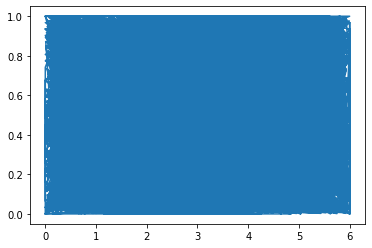

In [ ]:
plt.plot(x_f,y_f)

#Adding boundary collocation points to the bottom wall

In [ ]:
#bottom
lb1=np.zeros(3)
ub1=np.ones(3)
ub1[0]=xmax
ub1[1]=0.02
X_f_train11_new = lb1 + (ub1 - lb1) * lhs(3, int(N_f/5))

x_f_new = tf.convert_to_tensor(X_f_train11_new[:, 0:1], dtype=tf.float32)
y_f_new = tf.convert_to_tensor(X_f_train11_new[:, 1:2], dtype=tf.float32)

x_f=np.array(x_f)
y_f=np.array(y_f)

x_f =np.vstack((x_f,X_f_train11_new[:, 0:1]))
y_f =np.vstack((y_f,X_f_train11_new[:, 1:2]))

x_f=tf.convert_to_tensor(x_f, dtype=tf.float32)
y_f=tf.convert_to_tensor(y_f, dtype=tf.float32)
#plt.ylim([0,0.1])

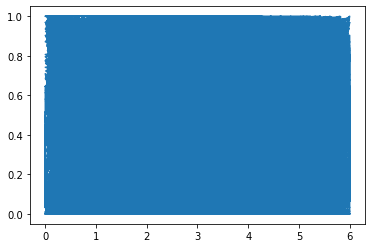

In [ ]:
plt.plot(x_f,y_f)

#Adding boundary collocation points to the top wall

In [ ]:
#top
lb1=np.zeros(3)
ub1=np.ones(3)
ub1[0]=xmax
lb1[1]=0.98
ub1[1]=1.0
X_f_train11_new = lb1 + (ub1 - lb1) * lhs(3, int(N_f/5))

x_f_new = tf.convert_to_tensor(X_f_train11_new[:, 0:1], dtype=tf.float32)
y_f_new = tf.convert_to_tensor(X_f_train11_new[:, 1:2], dtype=tf.float32)

x_f=np.array(x_f)
y_f=np.array(y_f)

x_f =np.vstack((x_f,X_f_train11_new[:, 0:1]))
y_f =np.vstack((y_f,X_f_train11_new[:, 1:2]))

x_f=tf.convert_to_tensor(x_f, dtype=tf.float32)
y_f=tf.convert_to_tensor(y_f, dtype=tf.float32)
#plt.ylim([0,0.1])

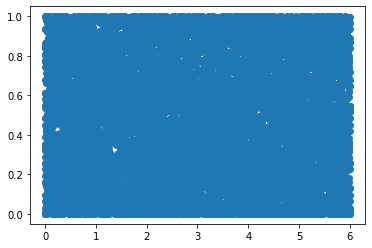

In [ ]:
plt.scatter(x_f,y_f)
#plt.ylim([0,0.2])

#Defining the equations


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set number of data points
#N_0 = 100
#N_b = 100
#N_r = 5000

N_b = Nu1
N_r = N_f


# Set boundary
xmin = 0.
#xmax = 8.
ymin = 0.
ymax = 1.
# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def Nsx(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*u_x-v*u_y-p_x+(1.0/1.0)*(u_xx+u_yy)
#    return -p_x+(1.0/1.0)*(u_xx+u_yy)


def Nsy(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*v_x-v*v_y-p_y+(1.0/1.0)*(v_xx+v_yy)
#    return -p_y+(1.0/1.0)*(v_xx+v_yy)

def Cont(u, v, u_x, u_y, v_x, v_y):
    return u_x+v_y

def concentration(u,v,c_x,c_y,c_xx,c_yy):
  return u*c_x+v*c_y-(1/(10*10))*(c_xx+c_yy)

def temperature(u,v,T_x,T_y,T_xx,T_yy,c_xx,c_yy):
  return ((u*T_x) +(v*T_y))-(1/(10*9.4)*(T_xx+T_yy))-((1/(10*10))*(((4200/3335)*(c_xx))+((4200/3335)*(c_yy))+((2470/3335)*(1-c_xx))+((2470/3335)*(1-c_yy))))

def sai(sai,sai_x,sai_y,sai_xx,sai_yy):
  return ((sai_xx)+(sai_yy))-6*sai

def fi(fi,fi_x,fi_y,fi_xx,fi_yy):
  return ((fi_xx)+(fi_yy))

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
x_0 = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_0 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0, y_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
x_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b, y_b)


# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

#Defining collocation point on the boundary

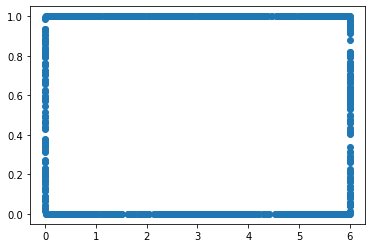

In [ ]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set number of data points
#N_0 = 100
#N_b = 100
#N_r = 5000

N_b = Nu1
N_r = N_f


LL=10/8

lo=np.zeros((N_b,1))
#top1
Nb_2= 80
xtt1= tf.random.uniform((Nb_2,1),0.0,LL, dtype=DTYPE)
ytt1= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt1=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt1=tf.zeros((Nb_2,1), dtype=DTYPE)

#top2
xtt2= tf.random.uniform((Nb_2,1),LL,2*LL, dtype=DTYPE)
ytt2= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt2=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt2=tf.zeros((Nb_2,1), dtype=DTYPE)

#top3
xtt3= tf.random.uniform((Nb_2,1),2*LL,3*LL, dtype=DTYPE)
ytt3= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt3=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt3=tf.zeros((Nb_2,1), dtype=DTYPE)

#top4
xtt4= tf.random.uniform((Nb_2,1),3*LL,4*LL, dtype=DTYPE)
ytt4= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt4=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt4=tf.zeros((Nb_2,1), dtype=DTYPE)

#top5
xtt5= tf.random.uniform((Nb_2,1),4*LL,4.5*LL, dtype=DTYPE)
ytt5= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt5=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt5=tf.zeros((Nb_2,1), dtype=DTYPE)

#top6
xtt6= tf.random.uniform((Nb_2,1),4.5*LL,xmax, dtype=DTYPE)
ytt6= tf.constant(1.0,shape=(Nb_2,1), dtype=DTYPE)
utt6=tf.zeros((Nb_2,1), dtype=DTYPE)
vtt6=tf.zeros((Nb_2,1), dtype=DTYPE)


#bottom1
Nb_2=80
xbb1= tf.random.uniform((Nb_2,1),0.0,LL, dtype=DTYPE)
ybb1= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb1=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb1=tf.zeros((Nb_2,1), dtype=DTYPE)

#bottom2
Nb_2= 80
xbb2= tf.random.uniform((Nb_2,1),LL,2*LL, dtype=DTYPE)
ybb2= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb2=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb2=tf.zeros((Nb_2,1), dtype=DTYPE)

#bottom3
Nb_2= 80
xbb3= tf.random.uniform((Nb_2,1),2*LL,3*LL,dtype=DTYPE)
ybb3= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb3=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb3=tf.zeros((Nb_2,1), dtype=DTYPE)

#bottom4
Nb_2= 80
xbb4= tf.random.uniform((Nb_2,1),3*LL,4*LL, dtype=DTYPE)
ybb4= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb4=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb4=tf.zeros((Nb_2,1), dtype=DTYPE)

#bottom5
Nb_2= 80
xbb5= tf.random.uniform((Nb_2,1),4*LL,4.5*LL, dtype=DTYPE)
ybb5= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb5=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb5=tf.zeros((Nb_2,1), dtype=DTYPE)

#bottom6
Nb_2= 80
xbb6= tf.random.uniform((Nb_2,1),4.5*LL,xmax, dtype=DTYPE)
ybb6= tf.constant(0.0,shape=(Nb_2,1), dtype=DTYPE)
ubb6=tf.zeros((Nb_2,1), dtype=DTYPE)
vbb6=tf.zeros((Nb_2,1), dtype=DTYPE)


#left1
xx=[]
yy=[]
Nb_1= 50
xll1= tf.zeros((Nb_1,1), dtype=DTYPE)
yll1 =tf.random.uniform((Nb_1,1),0, 0.5, dtype=DTYPE)
#xll1=tf.add(xll1[:,0],xx)
#yll1=tf.add(yll1[:,0],yy)
ull1=tf.zeros((len(xx),1), dtype=DTYPE)
vll1=tf.zeros((len(xx),1), dtype=DTYPE)

#left2
xx=[]
yy=[]
Nb_2= 50
xll2= tf.zeros((Nb_2,1), dtype=DTYPE)
yll2= tf.random.uniform((Nb_2,1),0.5, 1.0, dtype=DTYPE)
#xll2=tf.zeros((len(xx),1), dtype=DTYPE)
#yll2=tf.zeros((len(yy),1), dtype=DTYPE)
#xll2=tf.add(xll2[:,0],xx)
#yll2=tf.add(yll2[:,0],yy)
ull2=tf.zeros((len(xx),1), dtype=DTYPE)
vll2=tf.zeros((len(xx),1), dtype=DTYPE)

#right

xx=[]
yy=[]
for i in range(N_b):
      if X_data[0][i,0].numpy() == xmax:
        xx.append(X_data[0][i,0].numpy())
        yy.append(X_data[0][i,1].numpy())
xrr=tf.zeros((len(xx),1), dtype=DTYPE)
yrr=tf.zeros((len(yy),1), dtype=DTYPE)
xrr=tf.add(xrr[:,0],xx)
yrr=tf.add(yrr[:,0],yy)
urr=tf.zeros((len(xx),1), dtype=DTYPE)
vrr=tf.zeros((len(xx),1), dtype=DTYPE)

xtt1=tf.reshape(xtt1,shape=[tf.shape(xtt1).numpy()[0],1])
ytt1=tf.reshape(ytt1,shape=[tf.shape(ytt1).numpy()[0],1])

xtt2=tf.reshape(xtt2,shape=[tf.shape(xtt2).numpy()[0],1])
ytt2=tf.reshape(ytt2,shape=[tf.shape(ytt2).numpy()[0],1])

xtt3=tf.reshape(xtt3,shape=[tf.shape(xtt3).numpy()[0],1])
ytt3=tf.reshape(ytt3,shape=[tf.shape(ytt3).numpy()[0],1])

xtt4=tf.reshape(xtt4,shape=[tf.shape(xtt4).numpy()[0],1])
ytt4=tf.reshape(ytt4,shape=[tf.shape(ytt4).numpy()[0],1])

#xbb1=tf.reshape(xbb1,shape=[tf.shape(xbb1).numpy()[0],1])
#ybb1=tf.reshape(ybb1,shape=[tf.shape(ybb1).numpy()[0],1])

#xbb2=tf.reshape(xbb1,shape=[tf.shape(xbb2).numpy()[0],1])
#ybb2=tf.reshape(ybb1,shape=[tf.shape(ybb2).numpy()[0],1])

#xbb3=tf.reshape(xbb1,shape=[tf.shape(xbb3).numpy()[0],1])
#ybb3=tf.reshape(ybb1,shape=[tf.shape(ybb3).numpy()[0],1])

#xbb4=tf.reshape(xbb1,shape=[tf.shape(xbb4).numpy()[0],1])
#ybb4=tf.reshape(ybb1,shape=[tf.shape(ybb4).numpy()[0],1])


xrr=tf.reshape(xrr,shape=[tf.shape(xrr).numpy()[0],1])
yrr=tf.reshape(yrr,shape=[tf.shape(yrr).numpy()[0],1])

xll1=tf.reshape(xll1,shape=[tf.shape(xll1).numpy()[0],1])
yll1=tf.reshape(yll1,shape=[tf.shape(yll1).numpy()[0],1])
xll2=tf.reshape(xll2,shape=[tf.shape(xll2).numpy()[0],1])
yll2=tf.reshape(yll2,shape=[tf.shape(yll2).numpy()[0],1])

xbound=tf.concat([xtt1,xtt2,xtt3,xtt4,xtt5,xtt6,xbb1,xbb2,xbb3,xbb4,xbb5,xbb6,xrr,xll1,xll2],0)
ybound=tf.concat([ytt1,ytt2,ytt3,ytt4,ytt5,ytt6,ybb1,ybb2,ybb3,ybb4,ybb5,ybb6,yrr,yll1,yll2],0)
#xbound=tf.concat([xtt1,xtt2,xtt3,xtt4,xbb1,xbb2,xbb3,xbb4],0)
#ybound=tf.concat([ytt1,ytt2,ytt3,ytt4,ybb1,ybb2,ybb3,ybb4],0)
plt.scatter(xbound,ybound)

ubound=tf.concat([utt1,utt2,utt3,utt4,utt5,utt6,ubb1,ubb2,ubb3,ubb4,ubb5,ubb6,urr,ull1,ull2],0)
vbound=tf.concat([vtt1,vtt2,vtt3,vtt4,vtt5,vtt6,vbb1,vbb2,vbb3,vbb4,vbb5,vbb6,vrr,vll1,vll2],0)

xb=xbound
yb=ybound

ub=ubound
vb=vbound
#plt.scatter(xbb2,ybb2)

#Solving ELectric layer due charged suraface on the wall

In [ ]:
#solving sai

# -*- coding: utf-8 -*-
"""
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs

weight_ub = tf.Variable([1000.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 7]
sizes_w = []
sizes_b = []
loss_saman=[]
list_model_sai=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))


# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)

def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]


    model_output = keras.models.Model(input_tensor, [output0])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,xtop1,xtop2,xtop3,xtop4,xtop5,xtop6,ytop1,ytop2,ytop3,ytop4,ytop5,ytop6,xbottom1,xbottom2,xbottom3,xbottom4,xbottom5,xbottom6,ybottom1,ybottom2,ybottom3,ybottom4,ybottom5,ybottom6,xright,yright,xleft1,yleft1,xleft2,yleft2):

    f_fi_pred= f_model(x_f_batch, y_f_batch)


    #sai_pred,fi_pred,u_pred,v_pred,p_pred,c_pred,T_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(xtop1,xtop2,xtop3,xtop4,xtop5,xtop6,ytop1,ytop2,ytop3,ytop4,ytop5,ytop6,xbottom1,xbottom2,xbottom3,xbottom4,xbottom5,xbottom6,ybottom1,ybottom2,ybottom3,ybottom4,ybottom5,ybottom6,xright,yright,xleft1,yleft1,xleft2,yleft2)
    mse_b = loss_2*weight_ub#+ mse_b

    mse_f = weight_fu*( tf.reduce_sum(tf.square(f_fi_pred)))
    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop1,xtop2,xtop3,xtop4,xtop5,xtop6,ytop1,ytop2,ytop3,ytop4,ytop5,ytop6,xbottom1,xbottom2,xbottom3,xbottom4,xbottom5,xbottom6,ybottom1,ybottom2,ybottom3,ybottom4,ybottom5,ybottom6,xright,yright,xleft1,yleft1,xleft2,yleft2):
  saitop1 = u_model(tf.concat([xtop1, ytop1],1))
  saitop2 = u_model(tf.concat([xtop2, ytop2],1))
  saitop3 = u_model(tf.concat([xtop3, ytop3],1))
  saitop4 = u_model(tf.concat([xtop4, ytop4],1))
  saitop5 = u_model(tf.concat([xtop5, ytop5],1))
  saitop6 = u_model(tf.concat([xtop6, ytop6],1))
  saibottom1 =u_model(tf.concat([xbottom1, ybottom1],1))
  saibottom2=u_model(tf.concat([xbottom2, ybottom2],1))
  saibottom3=u_model(tf.concat([xbottom3, ybottom3],1))
  saibottom4=u_model(tf.concat([xbottom4, ybottom4],1))
  saibottom5=u_model(tf.concat([xbottom5, ybottom5],1))
  saibottom6=u_model(tf.concat([xbottom6, ybottom6],1))
  sairight= u_model(tf.concat([xright, yright],1))
  saileft1= u_model(tf.concat([xleft1, yleft1],1))
  saileft2= u_model(tf.concat([xleft2, yleft2],1))

  #tf.print('ybb3*******',ybottom3)
  #tf.print('=======================pbottom',tf.shape(pbottom),'ybottom',tf.shape(ybottom)) reduce_sum

  loss_bd = tf.reduce_sum(tf.square(saitop1+1.0)) + tf.reduce_sum(tf.square(saitop2+0.0)) +tf.reduce_sum(tf.square(saitop3+1.0))\
  +tf.reduce_sum(tf.square(saitop4+0))+tf.reduce_sum(tf.square(saitop5+0))+tf.reduce_sum(tf.square(saitop6-0))\
  +tf.reduce_sum(tf.square(saibottom1-0.0)) + tf.reduce_sum(tf.square(saibottom2+1.0)) +tf.reduce_sum(tf.square(saibottom3-0.0))\
  +tf.reduce_sum(tf.square(saibottom4+1.0)) + tf.reduce_sum(tf.square(saibottom5+0.0)) +tf.reduce_sum(tf.square(saibottom6+0.0))\
  +tf.reduce_sum(tf.square(tf.gradients(saileft1,xleft1)[0]))+tf.reduce_sum(tf.square(tf.gradients(saileft2,xleft2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(sairight,xright)[0]))\


  #loss_bd = 0

  return loss_bd


@tf.function
def f_model(x, y):

    sai= u_model(tf.concat([x, y],1))

    #fi_t = tf.gradients(fi, t)[0]
    sai_x= tf.gradients(sai, x)[0]
    sai_y= tf.gradients(sai, y)[0]
    sai_xx= tf.gradients(sai_x, x)[0]
    sai_yy= tf.gradients(sai_y, y)[0]

    cc=tf.constant(60.0, dtype=tf.float32)
    f_sai=((sai_xx)+(sai_yy))-cc*sai

    #wh^2=6

    return f_sai

@tf.function
def u_x_model(x, y):
    sai= u_model(tf.concat([x, y], 1))
    return sai


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top1,x_top2,x_top3,x_top4,x_top5,x_top6,y_top1,y_top2,y_top3,y_top4,y_top5,y_top6,
         x_bottom1,x_bottom2,x_bottom3,x_bottom4,x_bottom5,x_bottom6,y_bottom1,y_bottom2,y_bottom3,y_bottom4,y_bottom5,y_bottom6,x_right,y_right,x_left1,y_left1,x_left2,y_left2):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch,vb_batch, weight_ub, weight_fu,x_top1,x_top2,x_top3,x_top4,x_top5,x_top6,y_top1,y_top2,y_top3,y_top4,y_top5,y_top6,
                                        x_bottom1,x_bottom2,x_bottom3,x_bottom4,x_bottom5,x_bottom6,y_bottom1,y_bottom2,y_bottom3,y_bottom4,y_bottom5,y_bottom6,
                                        x_right,y_right,x_left1,y_left1,x_left2,y_left2)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, sai_exact1, fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1, X_star,xtt1,xtt2,xtt3,xtt4,xtt5,xtt6,ytt1,ytt2,ytt3,ytt4,ytt5,ytt6,xbb1,xbb2,xbb3,xbb4,xbb5,xbb6,ybb1,ybb2,ybb3,ybb4,ybb5,ybb6,xrr,yrr,xll1,yll1,xll2,yll2, tf_iter, tf_iter2,newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.01, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top1=xtt1
            y_top1=ytt1

            x_top2=xtt2
            y_top2=ytt2

            x_top3=xtt3
            y_top3=ytt3

            x_top4=xtt4
            y_top4=ytt4

            x_top5=xtt5
            y_top5=ytt5

            x_top6=xtt6
            y_top6=ytt6

            x_bottom1=xbb1
            y_bottom1=ybb1

            x_bottom2=xbb2
            y_bottom2=ybb2

            x_bottom3=xbb3
            y_bottom3=ybb3

            x_bottom4=xbb4
            y_bottom4=ybb4

            x_bottom5=xbb5
            y_bottom5=ybb5

            x_bottom6=xbb6
            y_bottom6=ybb6

            x_right=xrr
            y_right=yrr

            x_left1=xll1
            y_left1=yll1

            x_left2=xll2
            y_left2=yll2

            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]


            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,x_top1,x_top2,x_top3,x_top4,x_top5,x_top6,y_top1,y_top2,y_top3,y_top4,y_top5,y_top6,
                                                                       x_bottom1,x_bottom2,x_bottom3,x_bottom4,x_bottom5,x_bottom6,y_bottom1,
                                                                       y_bottom2,y_bottom3,y_bottom4,y_bottom5,y_bottom6,x_right,y_right,x_left1,y_left1,x_left2,y_left2)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            list_model_sai.append(u_model)
            #if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
            #        loss_history[-10]:
            #    tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
            #    tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 40 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    fi_pred = predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman,list_model_sai

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    sai_star= u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return sai_star.numpy()


start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman, list_model_sai = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu,sai_exact1,
                                                   fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1,X_star1,xtt1,
                                                   xtt2,xtt3,xtt4,xtt5,xtt6,ytt1,ytt2,ytt3,ytt4,ytt5,ytt6,xbb1,xbb2,xbb3,xbb4,xbb5,xbb6,ybb1,ybb2,ybb3,ybb4,
                                                   ybb5,ybb6,xrr,yrr,xll1,yll1,xll2,yll2,tf_iter=340000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))




xxxxxxxxxxxxxx
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


It: 0, Time: 31.11
mse_b  [764202.1]  mse_f: [6817469.5]   total loss: [7581671.5]
It: 40, Time: 0.83
mse_b  [263126.94]  mse_f: [583952.6]   total loss: [847079.56]
It: 80, Time: 0.82
mse_b  [297577.16]  mse_f: [156278.9]   total loss: [453856.06]
It: 120, Time: 0.84
mse_b  [288567.3]  mse_f: [116999.445]   total loss: [405566.75]
It: 160, Time: 0.85
mse_b  [317277.8]  mse_f: [907.13947]   total loss: [318184.94]
It: 200, Time: 0.85
mse_b  [338686.9]  mse_f: [28032.852]   total loss: [366719.75]
It: 240, Time: 0.82
mse_b  [290479.]  mse_f: [90599.27]   total loss: [381078.28]
It: 280, Time: 0.85
mse_b  [316114.38]  mse_f: [1446.1598]   total loss: [317560.53]
It: 320, Time: 0.89
mse_b  [332052.38]  mse_f: [12385.115]   total loss: [344437.5]
It: 360, Time: 0.89
mse_b  [307066.9]  mse_f: [15549.521]   total loss: [322616.44]
It: 400, Time: 0.83
mse_b  [306292.53]  mse_f: [17429.752]   total loss: [323722.28]
It: 440, Time: 0.82
mse_b  [323688.9]  mse_f: [1338.9744]   total loss: [32502

KeyboardInterrupt: ignored

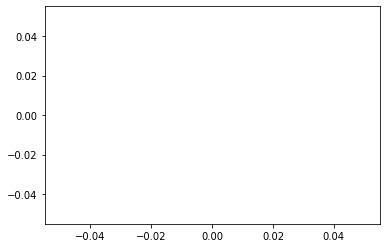

In [ ]:
plt.plot(loss_saman[14000:])

In [ ]:
import pandas as pd
loss2=[]
for i in range(len(loss_saman)):
  loss2.append(loss_saman[i][0].numpy())
print("Min: ", pd.Series(loss2).idxmin())
print("Max: ", pd.Series(loss2).idxmax())
print('loss_min',loss_saman[pd.Series(loss2).idxmin()])

model_sai=list_model_sai[pd.Series(loss2).idxmin()]

Min:  51520
Max:  1
loss_min tf.Tensor([2508.9917], shape=(1,), dtype=float32)


In [ ]:
model_sai.save('my_sai_model_Lx6_Asym_2top_2bott.h5')

In [ ]:
new_model = tf.keras.models.load_model('my_sai_model.h5')
model_sai=new_model

#Visualization of predicted electric layer using PINNs


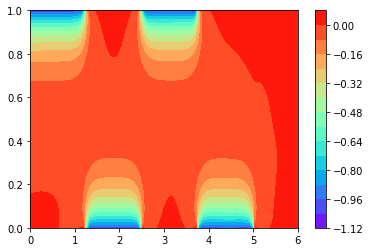

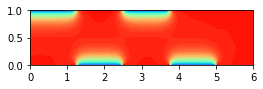

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# Set up meshgrid




N=100
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))

X_star = tf.convert_to_tensor(X_star1, dtype=tf.float32)
#up, vp, pp = u_x_model(X_star[:, 0:1], X_star[:, 1:2])

UU=model_sai(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))
uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)
plt. contourf(X1, Y1, U,16
              , cmap='rainbow');
plt.colorbar();


x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,60,cmap='rainbow')




#Running PINNs for soliving electric field distribution in the domain due to external electric field

In [ ]:
#FI
# -*- coding: utf-8 -*-
"""
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs

weight_ub = tf.Variable([10000.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 7]
sizes_w = []
sizes_b = []
loss_saman=[]
list_model_fi=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))


# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)


def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]


    model_output = keras.models.Model(input_tensor, [output0])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2):

    f_fi_pred= f_model(x_f_batch, y_f_batch)


    #sai_pred,fi_pred,u_pred,v_pred,p_pred,c_pred,T_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2)
    mse_b = loss_2*weight_ub#+ mse_b

    mse_f = weight_fu*( tf.reduce_sum(tf.square(f_fi_pred)))
    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2):
  ftop1 = u_model(tf.concat([xtop1, ytop1],1))
  ftop2 = u_model(tf.concat([xtop2, ytop2],1))
  ftop3 = u_model(tf.concat([xtop3, ytop3],1))
  ftop4 = u_model(tf.concat([xtop4, ytop4],1))
  fbottom1 =u_model(tf.concat([xbottom1, ybottom1],1))
  fbottom2=u_model(tf.concat([xbottom2, ybottom2],1))
  fbottom3=u_model(tf.concat([xbottom3, ybottom3],1))
  fbottom4=u_model(tf.concat([xbottom4, ybottom4],1))
  fright= u_model(tf.concat([xright, yright],1))
  fleft1= u_model(tf.concat([xleft1, yleft1],1))
  fleft2= u_model(tf.concat([xleft2, yleft2],1))

  #tf.print('ybb3*******',ybottom3)
  #tf.print('=======================pbottom',tf.shape(pbottom),'ybottom',tf.shape(ybottom)) reduce_sum

  loss_bd = tf.reduce_sum(tf.square(fright-0))\
  +tf.reduce_sum(tf.square(tf.gradients(ftop1,ytop1)[0]))+tf.reduce_sum(tf.square(tf.gradients(ftop2,ytop2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(ftop3,ytop3)[0]))+tf.reduce_sum(tf.square(tf.gradients(ftop4,ytop4)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(fbottom1,ybottom1)[0]))+tf.reduce_sum(tf.square(tf.gradients(fbottom2,ybottom2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(fbottom3,ybottom3)[0]))+tf.reduce_sum(tf.square(tf.gradients(fbottom4,ybottom4)[0]))\
  +tf.reduce_sum(tf.square(fleft1-1))+tf.reduce_sum(tf.square(fleft2-1))

  #loss_bd = 0

  return loss_bd


@tf.function
def f_model(x, y):

    fi= u_model(tf.concat([x, y],1))

    #fi_t = tf.gradients(fi, t)[0]
    fi_x= tf.gradients(fi, x)[0]
    fi_y= tf.gradients(fi, y)[0]
    fi_xx= tf.gradients(fi_x, x)[0]
    fi_yy= tf.gradients(fi_y, y)[0]

    f_fi=((fi_xx)+(fi_yy))

    #wh^2=6

    return f_fi

@tf.function
def u_x_model(x, y):
    fi= u_model(tf.concat([x, y], 1))
    return fi


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
         x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,y_bottom2,y_bottom3,y_bottom4,x_right,y_right,x_left1,y_left1,x_left2,y_left2):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch,vb_batch, weight_ub, weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
                                        x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,y_bottom2,y_bottom3,y_bottom4,
                                        x_right,y_right,x_left1,y_left1,x_left2,y_left2)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, sai_exact1, fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1, X_star,xtt1,xtt2,xtt3,xtt4,ytt1,ytt2,ytt3,ytt4,xbb1,xbb2,xbb3,xbb4,ybb1,ybb2,ybb3,ybb4,xrr,yrr,xll1,yll1,xll2,yll2, tf_iter, tf_iter2,newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top1=xtt1
            y_top1=ytt1

            x_top2=xtt2
            y_top2=ytt2

            x_top3=xtt3
            y_top3=ytt3

            x_top4=xtt4
            y_top4=ytt4

            x_bottom1=xbb1
            y_bottom1=ybb1

            x_bottom2=xbb2
            y_bottom2=ybb2

            x_bottom3=xbb3
            y_bottom3=ybb3

            x_bottom4=xbb4
            y_bottom4=ybb4

            x_right=xrr
            y_right=yrr

            x_left1=xll1
            y_left1=yll1

            x_left2=xll2
            y_left2=yll2

            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]


            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
                                                                       x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,
                                                                       y_bottom2,y_bottom3,y_bottom4,x_right,y_right,x_left1,y_left1,x_left2,y_left2)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            list_model_fi.append(u_model)
            #if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
            #        loss_history[-10]:
            #    tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
            #    tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 40 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    fi_pred = predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman, list_model

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    fi_star= u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return fi_star.numpy()


start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman, list_model_fi= fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu,sai_exact1,
                                                   fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1,X_star1,xtt1,
                                                   xtt2,xtt3,xtt4,ytt1,ytt2,ytt3,ytt4,xbb1,xbb2,xbb3,xbb4,ybb1,ybb2,ybb3,ybb4,
                                                   xrr,yrr,xll1,yll1,xll2,yll2,tf_iter=140000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


'''
N_f = 10000
Nu1 = 200

weight_ub = tf.Variable([1.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)

x1 = (np.linspace(0, 1, 32)).flatten()[:, None]
y1 = (np.linspace(0, 1, 32)).flatten()[:, None]
t1 = (np.linspace(0, 1, 20)).flatten()[:, None]

ttt1, ttt0 = np.meshgrid(x1, y1)

tt1 = np.concatenate(([ttt1.flatten()[:, None], ttt0.flatten()[:, None], np.zeros((x1.shape[0] * y1.shape[0], 1))]), axis=1)
x_1t = np.array([tt1[:, 0]]).T
y_1t = np.array([tt1[:, 1]]).T
t_1t = np.array([tt1[:, 2]]).T
ut1 = -np.sin(t_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.cos(np.pi * y_1t)
vt1 = np.sin(t_1t) * np.sin(np.pi * x_1t) * np.cos(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.sin(np.pi * y_1t)

yyy1, yyy0 = np.meshgrid(x1, t1)

yy1 = np.concatenate(
    ([yyy1.flatten()[:, None], np.min(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_1y = np.array([yy1[:, 0]]).T
y_1y = np.array([yy1[:, 1]]).T
t_1y = np.array([yy1[:, 2]]).T
uy1 = -np.sin(t_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.cos(np.pi * y_1y)
vy1 = np.sin(t_1y) * np.sin(np.pi * x_1y) * np.cos(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.sin(np.pi * y_1y)

yy2 = np.concatenate(
    ([yyy1.flatten()[:, None], np.max(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_2y = np.array([yy2[:, 0]]).T
y_2y = np.array([yy2[:, 1]]).T
t_2y = np.array([yy2[:, 2]]).T
uy2 = -np.sin(t_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.cos(np.pi * y_2y)
vy2 = np.sin(t_2y) * np.sin(np.pi * x_2y) * np.cos(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.sin(np.pi * y_2y)


xxx1, xxx0 = np.meshgrid(y1, t1)

xx1 = np.concatenate(
    ([np.min(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_1x = np.array([xx1[:, 0]]).T
y_1x = np.array([xx1[:, 1]]).T
t_1x = np.array([xx1[:, 2]]).T
ux1 = -np.sin(t_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.cos(np.pi * y_1x)
vx1 = np.sin(t_1x) * np.sin(np.pi * x_1x) * np.cos(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.sin(np.pi * y_1x)

xx2 = np.concatenate(
    ([np.max(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_2x = np.array([xx2[:, 0]]).T
y_2x = np.array([xx2[:, 1]]).T
t_2x = np.array([xx2[:, 2]]).T
ux2 = -np.sin(t_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.cos(np.pi * y_2x)
vx2 = np.sin(t_2x) * np.sin(np.pi * x_2x) * np.cos(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.sin(np.pi * y_2x)

X_u1 = np.vstack([tt1, yy1, yy2, xx1, xx2])
u1 = np.vstack([ut1, uy1, uy2, ux1, ux2])
v1 = np.vstack([vt1, vy1, vy2, vx1, vx2])

idx_1 = np.random.choice(X_u1.shape[0], Nu1, replace=False)
X_u_train = X_u1[idx_1, :]
u_train = u1[idx_1, :]
v_train = v1[idx_1, :]

X1, Y1, T1 = np.meshgrid(x1, y1, t1)
#    Exact = np.sin(np.pi*X)*np.sin(np.pi*T)*np.sin(np.pi*Z)  #100*100*100
U_exact1 = -np.sin(T1) * np.sin(np.pi * X1) * np.sin(np.pi * X1) * np.sin(np.pi * Y1) * np.cos(np.pi * Y1)
V_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * X1) * np.sin(np.pi * Y1) * np.sin(np.pi * Y1)
P_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None], T1.flatten()[:, None]))
x_star1 = np.array([X_star1[:, 0]]).T
y_star1 = np.array([X_star1[:, 1]]).T
t_star1 = np.array([X_star1[:, 2]]).T

u_exact1 = -np.sin(t_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.cos(np.pi * y_star1)
v_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.sin(np.pi * y_star1)
p_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)

lb1 = X_star1.min(0)
ub1 = X_star1.max(0)

X_f_train11 = lb1 + (ub1 - lb1) * lhs(3, N_f)
X_f = np.vstack((X_f_train11, X_u_train))

xb = tf.cast(X_u_train[:, 0:1], dtype=tf.float32)
yb = tf.cast(X_u_train[:, 1:2], dtype=tf.float32)
tb = tf.cast(X_u_train[:, 2:3], dtype=tf.float32)
ub = tf.cast(u_train[:, 0:1], dtype=tf.float32)
vb = tf.cast(v_train[:, 0:1], dtype=tf.float32)


lb = X_star1.min(0)
rb = X_star1.max(0)

x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=tf.float32)
y_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f[:, 2:3], dtype=tf.float32)

start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1, tf_iter=10000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u_pred, v_pred, p_pred = predict(X_star1)

U_pred = u_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
V_pred = v_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
P_pred = p_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))

error_uu = np.abs(u_exact1 - u_pred)
error_vv = np.abs(v_exact1 - v_pred)
error_pp = np.abs(p_exact1 - p_pred)

error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
print('Error u: %e' % (error_u))

error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
print('Error v: %e' % (error_v))

error_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)
print('Error p: %e' % (error_p))

dataNewNS = 'D://NS_hisyory.mat'
scipy.io.savemat(dataNewNS, {'w_MSE_b': MSE_b1, 'w_MSE_f': MSE_f1, 'weight_u': weightu,
                  'weight_f': weightf, 'U_pred': U_pred, 'V_pred': V_pred, 'P_pred': P_pred})
'''

xxxxxxxxxxxxxx
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_32 (Dense)            (None, 20)                60        
                                                                 
 dense_33 (Dense)            (None, 20)                420       
                                                                 
 dense_34 (Dense)            (None, 20)                420       
                                                                 
 dense_35 (Dense)            (None, 20)                420       
                                                                 
 dense_36 (Dense)            (None, 20)                420       
                                                                 
 dense_37 (Dense)            (None, 20)     

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
loss2=[]
for i in range(len(loss_saman)):
  loss2.append(loss_saman[i][0].numpy())
print("Min: ", pd.Series(loss2).idxmin())
print("Max: ", pd.Series(loss2).idxmax())
print('loss_min',loss_saman[pd.Series(loss2).idxmin()])

model_fi=list_model_fi[pd.Series(loss2).idxmin()]

In [ ]:

model_fi.save('my_fi_model_Lx6_Asym_2top_2bott.h5')

In [ ]:
new_model = tf.keras.models.load_model('my_fi_model.h5')
model_fi= new_model

#Visualizing of predicted electric field

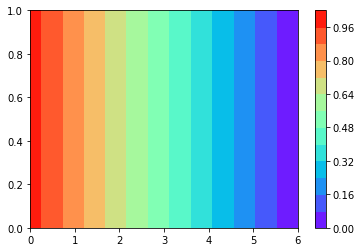

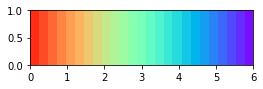

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# Set up meshgrid




N=100
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))

X_star = tf.convert_to_tensor(X_star1, dtype=tf.float32)
#up, vp, pp = u_x_model(X_star[:, 0:1], X_star[:, 1:2])

UU=model_fi(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))
uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)
plt. contourf(X1, Y1, U,15, cmap='rainbow');
plt.colorbar();


x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,30,cmap='rainbow')




In [ ]:
xcor1=x_f[0 * N_f:(0 * N_f + N_f), ]
ycor1=y_f[0 * N_f:(0 * N_f + N_f), ]
sai_ref = model_sai(tf.concat([xcor1,ycor1],1))

fi_ref = model_fi(tf.concat([xcor1,ycor1],1))

#distribution of eletric layer with respect to distance from the wall

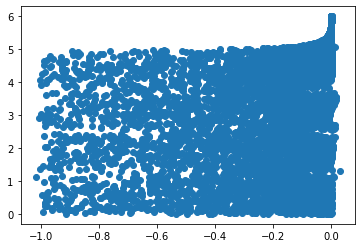

In [ ]:

plt.scatter(sai_ref,xcor1)

In [ ]:
x_f,sai_ref,fi_ref

#Calculation of derivative of fi with respect to x and y

In [ ]:
with tf.GradientTape(persistent=True)as tape:
  tape.watch(xcor1)
  tape.watch(xcor1)
  fi1_ref = model_fi(tf.stack([xcor1,ycor1],axis=1))
  fi_ref_x=tape.gradient(fi1_ref,xcor1)


#Solving Navier-Stoke euqation for finding velocity, pressure

xxxxxxxxxxxxxx
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_48 (Dense)               (None, 20)           60          ['input_7[0][0]']                
                                                                                                  
 dense_49 (Dense)               (None, 20)           420         ['dense_48[0][0]']               
                                                                                                  
 dense_50 (Dense)               (None, 20)           420         ['dense_49[0][0]']               
                                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
mse_b  [870.49426]  mse_f: 4.674972057342529   total loss: [875.16925]
mse_b ====== [872.417114]
It: 52654, Time: 0.03
mse_b  [872.4171]  mse_f: 4.777572154998779   total loss: [877.1947]
mse_b ====== [867.375122]
It: 52655, Time: 0.03
mse_b  [867.3751]  mse_f: 3.3015589714050293   total loss: [870.6767]
mse_b ====== [869.21051]
It: 52656, Time: 0.03
mse_b  [869.2105]  mse_f: 4.195425033569336   total loss: [873.40594]
mse_b ====== [873.10376]
It: 52657, Time: 0.04
mse_b  [873.10376]  mse_f: 4.5998125076293945   total loss: [877.70355]
mse_b ====== [867.900696]
It: 52658, Time: 0.03
mse_b  [867.9007]  mse_f: 4.236873149871826   total loss: [872.1376]
mse_b ====== [867.964905]
It: 52659, Time: 0.03
mse_b  [867.9649]  mse_f: 3.8473238945007324   total loss: [871.81226]
mse_b ====== [872.243]
It: 52660, Time: 0.03
mse_b  [872.243]  mse_f: 4.734940528869629   total loss: [876.9779]
mse_b ====== [868.67749]
It: 52661, Time: 0.03
mse_b  [868

KeyboardInterrupt: ignored

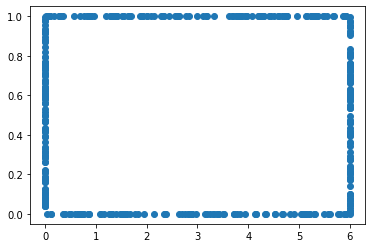

In [ ]:
#NEW NS with importing fi and sai
#NEW NS
#########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set number of data points
#N_0 = 100
#N_b = 100
#N_r = 5000

N_b = Nu1
N_r = N_f


# Set boundary
xmin = 0.
xmax = xmax
ymin = 0.
ymax = 1.
# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def Nsx(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*u_x-v*u_y-p_x+(1.0/1.0)*(u_xx+u_yy)
#    return -p_x+(1.0/1.0)*(u_xx+u_yy)


def Nsy(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*v_x-v*v_y-p_y+(1.0/1.0)*(v_xx+v_yy)
#    return -p_y+(1.0/1.0)*(v_xx+v_yy)

def Cont(u, v, u_x, u_y, v_x, v_y):
    return u_x+v_y

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
x_0 = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_0 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0, y_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
x_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b, y_b)


# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]


##################
#################
lo=np.zeros((N_b,1))
#top
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 1.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xtt=tf.zeros((len(xx),1), dtype=DTYPE)
ytt=tf.zeros((len(yy),1), dtype=DTYPE)
xtt=tf.add(xtt[:,0],xx)
ytt=tf.add(ytt[:,0],yy)
utt=tf.ones((len(xx),1), dtype=DTYPE)
vtt=tf.zeros((len(xx),1), dtype=DTYPE)


#bottom
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 0.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xbb=tf.zeros((len(xx),1), dtype=DTYPE)
ybb=tf.zeros((len(yy),1), dtype=DTYPE)
xbb=tf.add(xbb[:,0],xx)
ybb=tf.add(ybb[:,0],yy)
ubb=tf.zeros((len(xx),1), dtype=DTYPE)
vbb=tf.zeros((len(xx),1), dtype=DTYPE)

#left
xx=[]
yy=[]
for i in range(N_b):
      if X_data[0][i,0].numpy() == 0:
        xx.append(X_data[0][i,0].numpy())
        yy.append(X_data[0][i,1].numpy())
xll=tf.zeros((len(xx),1), dtype=DTYPE)
yll=tf.zeros((len(yy),1), dtype=DTYPE)
xll=tf.add(xll[:,0],xx)
yll=tf.add(yll[:,0],yy)
ull=tf.zeros((len(xx),1), dtype=DTYPE)
vll=tf.zeros((len(xx),1), dtype=DTYPE)

#right

xx=[]
yy=[]
for i in range(N_b):
      if X_data[0][i,0].numpy() == xmax:
        xx.append(X_data[0][i,0].numpy())
        yy.append(X_data[0][i,1].numpy())
xrr=tf.zeros((len(xx),1), dtype=DTYPE)
yrr=tf.zeros((len(yy),1), dtype=DTYPE)
xrr=tf.add(xrr[:,0],xx)
yrr=tf.add(yrr[:,0],yy)
urr=tf.zeros((len(xx),1), dtype=DTYPE)
vrr=tf.zeros((len(xx),1), dtype=DTYPE)

xtt=tf.reshape(xtt,shape=[tf.shape(xtt).numpy()[0],1])
ytt=tf.reshape(ytt,shape=[tf.shape(ytt).numpy()[0],1])

xbb=tf.reshape(xbb,shape=[tf.shape(xbb).numpy()[0],1])
ybb=tf.reshape(ybb,shape=[tf.shape(ybb).numpy()[0],1])

xrr=tf.reshape(xrr,shape=[tf.shape(xrr).numpy()[0],1])
yrr=tf.reshape(yrr,shape=[tf.shape(yrr).numpy()[0],1])

xll=tf.reshape(xll,shape=[tf.shape(xll).numpy()[0],1])
yll=tf.reshape(yll,shape=[tf.shape(yll).numpy()[0],1])

xbound=tf.concat([xtt,xbb,xrr,xll],0)
ybound=tf.concat([ytt,ybb,yrr,yll],0)
plt.scatter(xbound,ybound)

ubound=tf.concat([utt,ubb,urr,ull],0)
vbound=tf.concat([vtt,vbb,vrr,vll],0)

xb=xbound
yb=ybound

ub=ubound
vb=vbound

##################

# -*- coding: utf-8 -*-
"""
Created on Sun Oct 24 13:02:32 2021

@author: SAMAN
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs


gh = tf.constant(0.01, dtype=tf.float32)
gg = tf.constant(9.8, dtype=tf.float32)
weight_ub = tf.Variable([8.0], dtype=tf.float32)  # weight_ub = tf.Variable([8.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)  # weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 3]
sizes_w = []
sizes_b = []
loss_saman=[]
list_model_u=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))



# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)


def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]
    output1 = output_tensor[:, 1:2]
    output2 = output_tensor[:, 2:3]

    model_output = keras.models.Model(input_tensor, [output0, output1, output2])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()

def gh1(pp):
  return pp


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left,y_left):

    f_u_pred, f_v_pred, div_pred = f_model(x_f_batch, y_f_batch)


    u_pred, v_pred, p_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left,y_left)
    ###mse_b = loss_bd(x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left,y_left)*weight_ub
    #mse_b = loss_2*weight_ub#+ mse_b

    #mse_f = weight_fu*(tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred)))
    loss3=(tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred)))
    ###mse_f=(tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred)))*weight_fu
    #weight_ub = tf.cond(loss3>loss_2,lambda:[loss_2/loss3],lambda:[1.0])
    #weight_fu = tf.cond(loss_2>loss3, lambda:[1.0],lambda:[loss3/loss_2])



    #weight_ub.assign([1.0])
    #weight_fu.assign([1.0])

    mse_b = loss_2 * weight_ub
    mse_f = loss3

    tf.print('mse_b ======',mse_b)

    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop,ytop,xbottom,ybottom,xright,yright,xleft,yleft):
  utop, vtop, ptop = u_model(tf.concat([xtop, ytop],1))
  ubottom, vbottom, pbottom = u_model(tf.concat([xbottom, ybottom],1))
  uright, vright, pright = u_model(tf.concat([xright, yright],1))
  uleft, vleft, pleft = u_model(tf.concat([xleft, yleft],1))

  #tf.print('=======================pbottom',tf.shape(pbottom),'ybottom',tf.shape(ybottom))
#  loss_bd = tf.reduce_sum(tf.square(tf.gradients(ptop, ytop)[0]))+tf.reduce_sum(tf.square(tf.gradients(pbottom, ybottom)[0])) \
#  + tf.reduce_sum(tf.square(pright))+tf.reduce_sum(tf.square(tf.gradients(pleft, xleft)[0])) \
#  + tf.reduce_sum(tf.square(uleft-1))+tf.reduce_sum(tf.square(utop))+tf.reduce_sum(tf.square(ubottom))  \
#  + tf.reduce_sum(tf.square(tf.gradients(uright, xright)[0]))  \
#  + tf.reduce_sum(tf.square(vleft))+tf.reduce_sum(tf.square(vtop))+tf.reduce_sum(tf.square(vbottom)) \
#  + tf.reduce_sum(tf.square(tf.gradients(vright, xright)[0]))


  loss_bd = tf.reduce_sum(tf.square(tf.gradients(ptop, ptop)[0]))+tf.reduce_sum(tf.square(tf.gradients(pbottom, ybottom)[0])) \
  + tf.reduce_sum(tf.square(pright))+tf.reduce_sum(tf.square(tf.gradients(pleft, xleft)[0])) \
  + tf.reduce_sum(tf.square(uleft-1))+tf.reduce_sum(tf.square(utop))+tf.reduce_sum(tf.square(ubottom))  \
  + tf.reduce_sum(tf.square(tf.gradients(uright,xright)[0]))\
  + tf.reduce_sum(tf.square(vleft))+tf.reduce_sum(tf.square(vtop))+tf.reduce_sum(tf.square(vbottom))\
  + tf.reduce_sum(tf.square(tf.gradients(vright,xright)[0]))
  return loss_bd


@tf.function
def f_model(x, y):
    u, v, p = u_model(tf.concat([x, y],1))

    #saii=model_sai(x,y)
    #fii=model_fi(x,y)

    #fii_x=tf.gradients(fii,x)[0]


    #u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    #v_t = tf.gradients(v, t)[0]
    v_x = tf.gradients(v, x)[0]
    v_y = tf.gradients(v, y)[0]
    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]

    p_x = tf.gradients(p, x)[0]
    p_y = tf.gradients(p, y)[0]

    #bu, bv, bp = u_model(tf.concat([bx, by],1))
    #c1=gh1(gh)
    #c2=gh1(gg)
    #c2 = tf.constant(9.8, dtype=tf.float32)

    c1 = tf.constant(0.05, dtype=tf.float32)
    omega=tf.constant(7.0, dtype=tf.float32)
    Lxx=tf.constant(6.0, dtype=tf.float32)

    div = u_x + v_y

    #(1.0/Re)*(double(Lx)/double(Ly))*omega_h*omega_h*sai[i][j]*(fi[i+1][j]-fi[i-1][j])/double(2*dx);//inja kamel shavad
    f_u = u*u_x + v*u_y + p_x -c1*(u_xx + u_yy) - c1*omega*omega*sai_ref*fi_ref_x*Lxx #+ kk # c33*c22*sai*fii_x/c44# - ((np.pi)*tf.cos(np.pi*x)*tf.cos(np.pi*y)*tf.sin(t) - tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.cos(t) + \
    #c1*(2*(np.pi)**2*(tf.cos(np.pi*x))**2*tf.cos(np.pi*y)*tf.sin(np.pi*y)*tf.sin(t) - 6*(np.pi)**2*tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.sin(t)) - \
    #tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.sin(t)*(np.pi*(tf.cos(np.pi*y))**2*(tf.sin(np.pi*x))**2*tf.sin(t) - np.pi*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t)) +\
    #2*np.pi*tf.cos(np.pi*x)*(tf.cos(np.pi*y))**2*(tf.sin(np.pi*x))**3*(tf.sin(np.pi*y))**2*(tf.sin(t))**2)

    f_v = u*v_x + v*v_y + p_y - c1*(v_xx + v_yy) #- (tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.cos(t) - np.pi*tf.sin(np.pi*x)*tf.sin(np.pi*y)*tf.sin(t) - \
    #c1*(2*(np.pi)**2*tf.cos(np.pi*x)*(tf.cos(np.pi*y))**2*tf.sin(np.pi*x)*tf.sin(t) - 6*(np.pi)**2*tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.sin(t)) -\
    #tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.sin(t)*(np.pi*(tf.cos(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t) -\
    #np.pi*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t)) + 2*np.pi*(tf.cos(np.pi*x))**2*tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**3*(tf.sin(t))**2)

    return f_u, f_v, div

@tf.function
def u_x_model(x, y):
    u, v, w = u_model(tf.concat([x, y], 1))
    return u, v, w


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left,y_left):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch,  xb_batch, yb_batch, ub_batch,
                                        vb_batch, weight_ub, weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left,y_left)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star,xtt,ytt,xbb,ybb,xrr,yrr,xll,yll, tf_iter, tf_iter2,
        newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99) #tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top=xtt
            y_top=ytt

            x_bottom=xbb
            y_bottom=ybb

            x_right=xrr
            y_right=yrr

            x_left=xll
            y_left=yll


            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]

            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,
                                                                       x_top,y_top,x_bottom,y_bottom,
                                                                       x_right,y_right,x_left,y_left)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            list_model_u.append(u_model)
#            if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
#                    loss_history[-10]:
#                tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
#                tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 1 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    u_pred, v_pred, p_pred = predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,
                           ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    u_star, v_star, p_star = u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return u_star.numpy(), v_star.numpy(), p_star.numpy()


start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman, list_model_u = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1,xtt,ytt,xbb,ybb,xrr,yrr,xll,yll,
                                                                 tf_iter=300000,
                                                                 tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


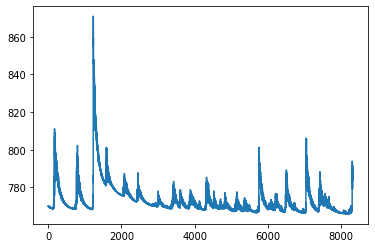

In [ ]:
plt.plot(loss_saman[40000:])

In [ ]:
loss_saman[0].numpy()

array([11909.92], dtype=float32)

In [ ]:
import pandas as pd
loss2=[]
for i in range(len(loss_saman)):
  loss2.append(loss_saman[i][0].numpy())
print("Min: ", pd.Series(loss2).idxmin())
print("Max: ", pd.Series(loss2).idxmax())
print('loss_min',loss_saman[pd.Series(loss2).idxmin()])

model_u=list_model_u[pd.Series(loss2).idxmin()]

Min:  53995
Max:  0
loss_min tf.Tensor([868.9242], shape=(1,), dtype=float32)


In [ ]:
model_u.save('my_u_model_Lx6_Asym_2top_2bott2.h5')

In [ ]:
new_model = tf.keras.models.load_model('my_u_model_Lx6_Asym_2top_2bott.h5')
model_u=new_model

#Visualization of velocity

(0.0, 6.0, 0.0, 1.0)

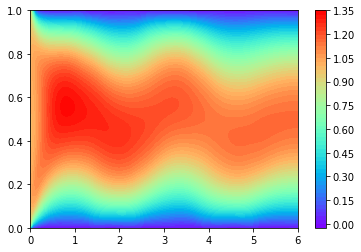

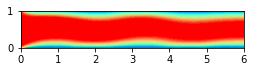

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# Set up meshgrid




N=100
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))

X_star = tf.convert_to_tensor(X_star1, dtype=tf.float32)
#up, vp, pp = u_x_model(X_star[:, 0:1], X_star[:, 1:2])

UU=new_model(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))[0]
uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)
plt. contourf(X1, Y1, U,60, cmap='rainbow');
plt.colorbar();


x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,60,vmax=1.0,cmap='rainbow')
plt.axis('scaled')


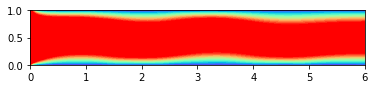

In [ ]:
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(6, 1))
ax.contourf(X1,Y1,U,60,vmax=0.8,cmap='rainbow')

In [ ]:
new_model_u = tf.keras.models.load_model('my_u_model_Lx6_Asym_2top_2bott.h5')

In [ ]:
new_model_u(tf.concat([xcor1,ycor1],1))


[<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
 array([[2.059567  ],
        [1.4083912 ],
        [0.6796989 ],
        ...,
        [1.454575  ],
        [0.67357385],
        [1.1621233 ]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
 array([[ 0.00255417],
        [-0.06266842],
        [-0.07143642],
        ...,
        [ 0.34537724],
        [-0.0191423 ],
        [ 0.24548493]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
 array([[0.3821262 ],
        [0.04062033],
        [0.77488816],
        ...,
        [1.6343566 ],
        [0.74118346],
        [1.1893368 ]], dtype=float32)>]

In [ ]:
xcor1=x_f[0 * N_f:(0 * N_f + N_f), ]
ycor1=y_f[0 * N_f:(0 * N_f + N_f), ]
u_ref, v_ref, p_ref = model_u(tf.concat([xcor1,ycor1],1))



#Running PINNs for solving Concentration

xxxxxxxxxxxxxx
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
mse_b  [1.2819963]  mse_f: 0.5324460864067078   total loss: [1.8144424]
mse_b ====== [1.27976704]
It: 2006, Time: 0.02
mse_b  [1.279767]  mse_f: 0.5320045948028564   total loss: [1.8117716]
mse_b ====== [1.27747595]
It: 2007, Time: 0.02
mse_b  [1.277476]  mse_f: 0.531452476978302   total loss: [1.8089285]
mse_b ====== [1.27522171]
It: 2008, Time: 0.02
mse_b  [1.2752217]  mse_f: 0.5311967134475708   total loss: [1.8064184]
mse_b ====== [1.2729969]
It: 2009, Time: 0.02
mse_b  [1.2729969]  mse_f: 0.531293511390686   total loss: [1.8042904]
mse_b ====== [1.27071762]
It: 2010, Time: 0.03
mse_b  [1.2707176]  mse_f: 0.5313593745231628   total loss: [1.802077]
mse_b ====== [1.2685349]
It: 2011, Time: 0.02
mse_b  [1.2685349]  mse_f: 0.5308915972709656   total loss: [1.7994266]
mse_b ====== [1.26629806]
It: 2012, Time: 0.02
mse_b  [1.266298]  mse_f: 0.5302547812461853   total loss: [1.7965529]
mse_b ====== [1.26410604]
It: 2013, Time: 0.02
mse_b

KeyboardInterrupt: ignored

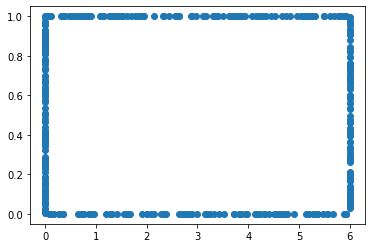

In [ ]:
#Solving C for electrowetting flow
#NEW NS with importing fi and sai
#NEW NS
#########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set number of data points
#N_0 = 100
#N_b = 100
#N_r = 5000

N_b = Nu1
N_r = N_f


# Set boundary
xmin = 0.
xmax = 6
ymin = 0.
ymax = 1.
# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def Nsx(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*u_x-v*u_y-p_x+(1.0/1.0)*(u_xx+u_yy)
#    return -p_x+(1.0/1.0)*(u_xx+u_yy)


def Nsy(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*v_x-v*v_y-p_y+(1.0/1.0)*(v_xx+v_yy)
#    return -p_y+(1.0/1.0)*(v_xx+v_yy)

def Cont(u, v, u_x, u_y, v_x, v_y):
    return u_x+v_y

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
x_0 = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_0 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0, y_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
x_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b, y_b)


# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]


##################
#################
lo=np.zeros((N_b,1))
#top
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 1.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xtt=tf.zeros((len(xx),1), dtype=DTYPE)
ytt=tf.zeros((len(yy),1), dtype=DTYPE)
xtt=tf.add(xtt[:,0],xx)
ytt=tf.add(ytt[:,0],yy)
utt=tf.ones((len(xx),1), dtype=DTYPE)
vtt=tf.zeros((len(xx),1), dtype=DTYPE)


#bottom
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 0.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xbb=tf.zeros((len(xx),1), dtype=DTYPE)
ybb=tf.zeros((len(yy),1), dtype=DTYPE)
xbb=tf.add(xbb[:,0],xx)
ybb=tf.add(ybb[:,0],yy)
ubb=tf.zeros((len(xx),1), dtype=DTYPE)
vbb=tf.zeros((len(xx),1), dtype=DTYPE)

#left1
xx=[]
yy=[]
Nb_1= 50
xll1= tf.zeros((Nb_1,1), dtype=DTYPE)
yll1 =tf.random.uniform((Nb_1,1),0, 0.5, dtype=DTYPE)
#xll1=tf.add(xll1[:,0],xx)
#yll1=tf.add(yll1[:,0],yy)
ull1=tf.zeros((len(xx),1), dtype=DTYPE)
vll1=tf.zeros((len(xx),1), dtype=DTYPE)

#left2
xx=[]
yy=[]
Nb_2= 50
xll2= tf.zeros((Nb_2,1), dtype=DTYPE)
yll2= tf.random.uniform((Nb_2,1),0.5, 1.0, dtype=DTYPE)
#xll2=tf.zeros((len(xx),1), dtype=DTYPE)
#yll2=tf.zeros((len(yy),1), dtype=DTYPE)
#xll2=tf.add(xll2[:,0],xx)
#yll2=tf.add(yll2[:,0],yy)
ull2=tf.zeros((len(xx),1), dtype=DTYPE)
vll2=tf.zeros((len(xx),1), dtype=DTYPE)

#right

xx=[]
yy=[]
for i in range(N_b):
      if X_data[0][i,0].numpy() == xmax:
        xx.append(X_data[0][i,0].numpy())
        yy.append(X_data[0][i,1].numpy())
xrr=tf.zeros((len(xx),1), dtype=DTYPE)
yrr=tf.zeros((len(yy),1), dtype=DTYPE)
xrr=tf.add(xrr[:,0],xx)
yrr=tf.add(yrr[:,0],yy)
urr=tf.zeros((len(xx),1), dtype=DTYPE)
vrr=tf.zeros((len(xx),1), dtype=DTYPE)

xtt=tf.reshape(xtt,shape=[tf.shape(xtt).numpy()[0],1])
ytt=tf.reshape(ytt,shape=[tf.shape(ytt).numpy()[0],1])

xbb=tf.reshape(xbb,shape=[tf.shape(xbb).numpy()[0],1])
ybb=tf.reshape(ybb,shape=[tf.shape(ybb).numpy()[0],1])

xrr=tf.reshape(xrr,shape=[tf.shape(xrr).numpy()[0],1])
yrr=tf.reshape(yrr,shape=[tf.shape(yrr).numpy()[0],1])


xll1=tf.reshape(xll1,shape=[tf.shape(xll1).numpy()[0],1])
yll1=tf.reshape(yll1,shape=[tf.shape(yll1).numpy()[0],1])
xll2=tf.reshape(xll2,shape=[tf.shape(xll2).numpy()[0],1])
yll2=tf.reshape(yll2,shape=[tf.shape(yll2).numpy()[0],1])

xbound=tf.concat([xtt,xbb,xrr,xll1,xll2],0)
ybound=tf.concat([ytt,ybb,yrr,yll1,yll2],0)
plt.scatter(xbound,ybound)

ubound=tf.concat([utt,ubb,urr,ull1,ull2],0)
vbound=tf.concat([vtt,vbb,vrr,vll1,vll2],0)

xb=xbound
yb=ybound

ub=ubound
vb=vbound

##################
#xcor1=x_f[0 * N_f:(0 * N_f + N_f), ]
#ycor1=y_f[0 * N_f:(0 * N_f + N_f), ]
#sai_ref = model_sai(tf.concat([xcor1,ycor1],1))

#fi_ref = model_fi(tf.concat([xcor1,ycor1],1))
##################

# -*- coding: utf-8 -*-
"""
Created on Sun Oct 24 13:02:32 2021

@author: SAMAN
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs


gh = tf.constant(0.01, dtype=tf.float32)
gg = tf.constant(9.8, dtype=tf.float32)
weight_ub = tf.Variable([5.0], dtype=tf.float32)  # weight_ub = tf.Variable([8.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)  # weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 3]
sizes_w = []
sizes_b = []
loss_saman=[]
list_model_u=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))



# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)


def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]


    model_output = keras.models.Model(input_tensor, [output0])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()

def gh1(pp):
  return pp


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2):

    f_c_pred = f_model(x_f_batch, y_f_batch)


    c_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2)
    #mse_b = loss_2*weight_ub#+ mse_b

    #mse_f = weight_fu*(tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred)))
    loss3=tf.reduce_sum(tf.square(f_c_pred))

    #weight_ub = tf.cond(loss3>loss_2,lambda:[loss_2/loss3],lambda:[1.0])
    #weight_fu = tf.cond(loss_2>loss3, lambda:[1.0],lambda:[loss3/loss_2])



    #weight_ub.assign([1.0])
    #weight_fu.assign([1.0])

    mse_b = loss_2 * weight_ub
    mse_f = loss3

    tf.print('mse_b ======',mse_b)

    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop,ytop,xbottom,ybottom,xright,yright,xleft1,yleft1,xleft2,yleft2):
  ctop = u_model(tf.concat([xtop, ytop],1))
  cbottom = u_model(tf.concat([xbottom, ybottom],1))
  cright = u_model(tf.concat([xright, yright],1))
  cleft1 = u_model(tf.concat([xleft1, yleft1],1))
  cleft2 = u_model(tf.concat([xleft2, yleft2],1))



  loss_bd = tf.reduce_sum(tf.square(tf.gradients(ctop, ytop)[0]))+tf.reduce_sum(tf.square(tf.gradients(cbottom, ybottom)[0])) \
  + tf.reduce_sum(tf.square(tf.gradients(cright,xright)[0]))+tf.reduce_sum(tf.square(cleft1-0)) +tf.reduce_sum(tf.square(cleft2-1.0)) \

  return loss_bd


@tf.function
def f_model(x, y):
    c = u_model(tf.concat([x, y],1))

    c_x = tf.gradients(c, x)[0]
    c_y = tf.gradients(c, y)[0]
    c_xx = tf.gradients(c_x, x)[0]
    c_yy = tf.gradients(c_y, y)[0]



    Reynolds=tf.constant(100.0, dtype=tf.float32)
    Schimit= tf.constant(10, dtype=tf.float32)

    #(1.0/Re)*(double(Lx)/double(Ly))*omega_h*omega_h*sai[i][j]*(fi[i+1][j]-fi[i-1][j])/double(2*dx);//inja kamel shavad
    f_c = u_ref*c_x + v_ref*c_y  -(1.0/Reynolds)*(1.0/Schimit)*(c_xx + c_yy)

    return f_c

@tf.function
def u_x_model(x, y):
    c= u_model(tf.concat([x, y], 1))
    return c


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch,  xb_batch, yb_batch, ub_batch,
                                        vb_batch, weight_ub, weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star,xtt,ytt,xbb,ybb,xrr,yrr,xll1,yll1,xll2,yll2, tf_iter, tf_iter2,
        newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99) #tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top=xtt
            y_top=ytt

            x_bottom=xbb
            y_bottom=ybb

            x_right=xrr
            y_right=yrr

            x_left1=xll1
            y_left1=yll1

            x_left2=xll2
            y_left2=yll2

            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]

            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,
                                                                       x_top,y_top,x_bottom,y_bottom,
                                                                       x_right,y_right,x_left1,y_left1,x_left2,y_left2)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            list_model_u.append(u_model)
#            if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
#                    loss_history[-10]:
#                tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
#                tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 1 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    c_pred= predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,
                           ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    c_star = u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return c_star.numpy()

start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman, list_model_u = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1,xtt,ytt,xbb,ybb,xrr,yrr,xll1,yll1,xll2,yll2,
                                                                 tf_iter=300000,
                                                                 tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


In [ ]:
import pandas as pd
loss2=[]
for i in range(len(loss_saman)):
  loss2.append(loss_saman[i][0].numpy())
print("Min: ", pd.Series(loss2).idxmin())
print("Max: ", pd.Series(loss2).idxmax())
print('loss_min',loss_saman[pd.Series(loss2).idxmin()])

model_u=list_model_u[pd.Series(loss2).idxmin()]

Min:  3671
Max:  0
loss_min tf.Tensor([0.1792144], shape=(1,), dtype=float32)


#Visualization of concentration

Text(0.5, 1.0, 'CFD')

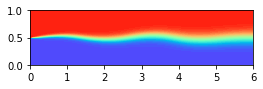

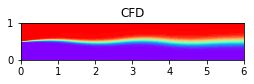

In [ ]:
N=100
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))

X_star = tf.convert_to_tensor(X_star1, dtype=tf.float32)
#up, vp, pp = u_x_model(X_star[:, 0:1], X_star[:, 1:2])

UU=model_u(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))

uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)

x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,80,cmap='rainbow')

x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,60,vmax=1.0,vmin=0,cmap='rainbow')
plt.axis('scaled')
plt.title('CFD')


(0.0, 6.0, 0.0, 1.0)

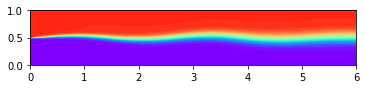

In [ ]:
#concentration for electrowetting

UU=model_u(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))
uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)
plt.figure(figsize=(6,1))
plt. contourf(X1, Y1, U,60,vmin=0, cmap='rainbow');
#plt.colorbar();
plt.axis('scaled')

In [ ]:
u_ref,v_ref

(<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
 array([[1.1425333 ],
        [1.1266822 ],
        [0.14481366],
        ...,
        [1.1369725 ],
        [0.5432961 ],
        [0.55365133]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
 array([[ 0.20608276],
        [-0.06612173],
        [-0.00921361],
        ...,
        [ 0.05409827],
        [-0.01267004],
        [ 0.0223068 ]], dtype=float32)>)

#Running PINNs for solving temperature

xxxxxxxxxxxxxx
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
It: 37188, Time: 0.02
mse_b  [0.7444893]  mse_f: 2.7204155921936035   total loss: [3.4649048]
mse_b ====== [0.291953623]
It: 37189, Time: 0.02
mse_b  [0.29195362]  mse_f: 2.2519025802612305   total loss: [2.5438561]
mse_b ====== [0.300016284]
It: 37190, Time: 0.02
mse_b  [0.30001628]  mse_f: 1.5224885940551758   total loss: [1.8225049]
mse_b ====== [0.251965672]
It: 37191, Time: 0.02
mse_b  [0.25196567]  mse_f: 3.557494640350342   total loss: [3.8094604]
mse_b ====== [0.525062442]
It: 37192, Time: 0.02
mse_b  [0.52506244]  mse_f: 1.917737603187561   total loss: [2.4428]
mse_b ====== [0.557005227]
It: 37193, Time: 0.03
mse_b  [0.5570052]  mse_f: 2.1800177097320557   total loss: [2.7370229]
mse_b ====== [0.245094806]
It: 37194, Time: 0.02
mse_b  [0.2450948]  mse_f: 2.907198905944824   total loss: [3.1522937]
mse_b ====== [0.31448409]
It: 37195, Time: 0.02
mse_b  [0.3144841]  mse_f: 0.9589430093765259   total loss: [1.2734271]
mse_b =====

KeyboardInterrupt: ignored

mse_b ====== [1.37095857]
It: 38855, Time: 0.02
mse_b  [1.3709586]  mse_f: 1.5436680316925049   total loss: [2.9146266]
mse_b ====== [1.19994009]
It: 38856, Time: 0.02
mse_b  [1.1999401]  mse_f: 1.5767097473144531   total loss: [2.77665]
mse_b ====== [0.996786833]
It: 38857, Time: 0.02
mse_b  [0.99678683]  mse_f: 1.7296292781829834   total loss: [2.726416]
mse_b ====== [0.847109258]
It: 38858, Time: 0.02
mse_b  [0.84710926]  mse_f: 1.6192684173583984   total loss: [2.4663777]
mse_b ====== [0.885418892]
It: 38859, Time: 0.02
mse_b  [0.8854189]  mse_f: 1.978132963180542   total loss: [2.8635519]
mse_b ====== [0.876563489]
It: 38860, Time: 0.02
mse_b  [0.8765635]  mse_f: 1.6597033739089966   total loss: [2.5362668]
mse_b ====== [0.839564502]
It: 38861, Time: 0.02
mse_b  [0.8395645]  mse_f: 1.811680793762207   total loss: [2.6512454]
mse_b ====== [0.949658513]
It: 38862, Time: 0.03
mse_b  [0.9496585]  mse_f: 1.9837899208068848   total loss: [2.9334483]
mse_b ====== [1.21491718]
It: 38863, 

KeyboardInterrupt: ignored

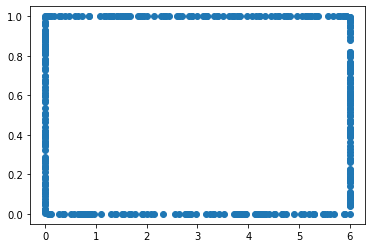

In [ ]:
#Solving Tem for electrowetting flow
#NEW NS with importing fi and sai
#NEW NS
#########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Set number of data points
#N_0 = 100
#N_b = 100
#N_r = 5000

N_b = Nu1
N_r = N_f


# Set boundary
xmin = 0.
xmax = 6
ymin = 0.
ymax = 1.
# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def Nsx(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*u_x-v*u_y-p_x+(1.0/1.0)*(u_xx+u_yy)
#    return -p_x+(1.0/1.0)*(u_xx+u_yy)


def Nsy(x, y, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y):
    return -u*v_x-v*v_y-p_y+(1.0/1.0)*(v_xx+v_yy)
#    return -p_y+(1.0/1.0)*(v_xx+v_yy)

def Cont(u, v, u_x, u_y, v_x, v_y):
    return u_x+v_y

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
x_0 = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
y_0 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0, y_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
x_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b, y_b)


# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]


##################
#################
lo=np.zeros((N_b,1))
#top
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 1.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xtt=tf.zeros((len(xx),1), dtype=DTYPE)
ytt=tf.zeros((len(yy),1), dtype=DTYPE)
xtt=tf.add(xtt[:,0],xx)
ytt=tf.add(ytt[:,0],yy)
utt=tf.ones((len(xx),1), dtype=DTYPE)
vtt=tf.zeros((len(xx),1), dtype=DTYPE)


#bottom
xx=[]
yy=[]
for i in range(N_b):
      if X_data[1][i,1].numpy() == 0.0:
        xx.append(X_data[1][i,0].numpy())
        yy.append(X_data[1][i,1].numpy())
xbb=tf.zeros((len(xx),1), dtype=DTYPE)
ybb=tf.zeros((len(yy),1), dtype=DTYPE)
xbb=tf.add(xbb[:,0],xx)
ybb=tf.add(ybb[:,0],yy)
ubb=tf.zeros((len(xx),1), dtype=DTYPE)
vbb=tf.zeros((len(xx),1), dtype=DTYPE)

#left1
xx=[]
yy=[]
Nb_1= 50
xll1= tf.zeros((Nb_1,1), dtype=DTYPE)
yll1 =tf.random.uniform((Nb_1,1),0, 0.5, dtype=DTYPE)
#xll1=tf.add(xll1[:,0],xx)
#yll1=tf.add(yll1[:,0],yy)
ull1=tf.zeros((len(xx),1), dtype=DTYPE)
vll1=tf.zeros((len(xx),1), dtype=DTYPE)

#left2
xx=[]
yy=[]
Nb_2= 50
xll2= tf.zeros((Nb_2,1), dtype=DTYPE)
yll2= tf.random.uniform((Nb_2,1),0.5, 1.0, dtype=DTYPE)
#xll2=tf.zeros((len(xx),1), dtype=DTYPE)
#yll2=tf.zeros((len(yy),1), dtype=DTYPE)
#xll2=tf.add(xll2[:,0],xx)
#yll2=tf.add(yll2[:,0],yy)
ull2=tf.zeros((len(xx),1), dtype=DTYPE)
vll2=tf.zeros((len(xx),1), dtype=DTYPE)

#right

xx=[]
yy=[]
for i in range(N_b):
      if X_data[0][i,0].numpy() == xmax:
        xx.append(X_data[0][i,0].numpy())
        yy.append(X_data[0][i,1].numpy())
xrr=tf.zeros((len(xx),1), dtype=DTYPE)
yrr=tf.zeros((len(yy),1), dtype=DTYPE)
xrr=tf.add(xrr[:,0],xx)
yrr=tf.add(yrr[:,0],yy)
urr=tf.zeros((len(xx),1), dtype=DTYPE)
vrr=tf.zeros((len(xx),1), dtype=DTYPE)

xtt=tf.reshape(xtt,shape=[tf.shape(xtt).numpy()[0],1])
ytt=tf.reshape(ytt,shape=[tf.shape(ytt).numpy()[0],1])

xbb=tf.reshape(xbb,shape=[tf.shape(xbb).numpy()[0],1])
ybb=tf.reshape(ybb,shape=[tf.shape(ybb).numpy()[0],1])

xrr=tf.reshape(xrr,shape=[tf.shape(xrr).numpy()[0],1])
yrr=tf.reshape(yrr,shape=[tf.shape(yrr).numpy()[0],1])


xll1=tf.reshape(xll1,shape=[tf.shape(xll1).numpy()[0],1])
yll1=tf.reshape(yll1,shape=[tf.shape(yll1).numpy()[0],1])
xll2=tf.reshape(xll2,shape=[tf.shape(xll2).numpy()[0],1])
yll2=tf.reshape(yll2,shape=[tf.shape(yll2).numpy()[0],1])

xbound=tf.concat([xtt,xbb,xrr,xll1,xll2],0)
ybound=tf.concat([ytt,ybb,yrr,yll1,yll2],0)
plt.scatter(xbound,ybound)

ubound=tf.concat([utt,ubb,urr,ull1,ull2],0)
vbound=tf.concat([vtt,vbb,vrr,vll1,vll2],0)

xb=xbound
yb=ybound

ub=ubound
vb=vbound

##################
#xcor1=x_f[0 * N_f:(0 * N_f + N_f), ]
#ycor1=y_f[0 * N_f:(0 * N_f + N_f), ]
#sai_ref = model_sai(tf.concat([xcor1,ycor1],1))

#fi_ref = model_fi(tf.concat([xcor1,ycor1],1))
##################

# -*- coding: utf-8 -*-
"""
Created on Sun Oct 24 13:02:32 2021

@author: SAMAN
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs


gh = tf.constant(0.01, dtype=tf.float32)
gg = tf.constant(9.8, dtype=tf.float32)
weight_ub = tf.Variable([5.0], dtype=tf.float32)  # weight_ub = tf.Variable([8.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)  # weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 3]
sizes_w = []
sizes_b = []
loss_saman=[]
list_model_u=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))



# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)


def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]


    model_output = keras.models.Model(input_tensor, [output0])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()

def gh1(pp):
  return pp


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2):

    f_c_pred = f_model(x_f_batch, y_f_batch)


    c_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2)
    #mse_b = loss_2*weight_ub#+ mse_b

    #mse_f = weight_fu*(tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred)))
    loss3=tf.reduce_sum(tf.square(f_c_pred))

    #weight_ub = tf.cond(loss3>loss_2,lambda:[loss_2/loss3],lambda:[1.0])
    #weight_fu = tf.cond(loss_2>loss3, lambda:[1.0],lambda:[loss3/loss_2])



    #weight_ub.assign([1.0])
    #weight_fu.assign([1.0])

    mse_b = loss_2 * weight_ub
    mse_f = loss3

    tf.print('mse_b ======',mse_b)

    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop,ytop,xbottom,ybottom,xright,yright,xleft1,yleft1,xleft2,yleft2):
  ctop = u_model(tf.concat([xtop, ytop],1))
  cbottom = u_model(tf.concat([xbottom, ybottom],1))
  cright = u_model(tf.concat([xright, yright],1))
  cleft1 = u_model(tf.concat([xleft1, yleft1],1))
  cleft2 = u_model(tf.concat([xleft2, yleft2],1))



  loss_bd = tf.reduce_sum(tf.square(ctop-1))+tf.reduce_sum(tf.square(cbottom-1)) \
  + tf.reduce_sum(tf.square(tf.gradients(cright,xright)[0]))+tf.reduce_sum(tf.square(cleft1-0.0)) +tf.reduce_sum(tf.square(cleft2-0.0)) \

  return loss_bd


@tf.function
def f_model(x, y):
    c = u_model(tf.concat([x, y],1))

    c_x = tf.gradients(c, x)[0]
    c_y = tf.gradients(c, y)[0]
    c_xx = tf.gradients(c_x, x)[0]
    c_yy = tf.gradients(c_y, y)[0]



    Reynolds=tf.constant(20.0, dtype=tf.float32)
    Schimit= tf.constant(9.4, dtype=tf.float32)

    #(1.0/Re)*(double(Lx)/double(Ly))*omega_h*omega_h*sai[i][j]*(fi[i+1][j]-fi[i-1][j])/double(2*dx);//inja kamel shavad
    f_c = u_ref*c_x + v_ref*c_y  -(1.0/Reynolds)*(1.0/Schimit)*(c_xx + c_yy)

    return f_c

@tf.function
def u_x_model(x, y):
    c= u_model(tf.concat([x, y], 1))
    return c


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch,  xb_batch, yb_batch, ub_batch,
                                        vb_batch, weight_ub, weight_fu,x_top,y_top,x_bottom,y_bottom,x_right,y_right,x_left1,y_left1,x_left2,y_left2)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star,xtt,ytt,xbb,ybb,xrr,yrr,xll1,yll1,xll2,yll2, tf_iter, tf_iter2,
        newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99) #tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top=xtt
            y_top=ytt

            x_bottom=xbb
            y_bottom=ybb

            x_right=xrr
            y_right=yrr

            x_left1=xll1
            y_left1=yll1

            x_left2=xll2
            y_left2=yll2

            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]

            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,
                                                                       x_top,y_top,x_bottom,y_bottom,
                                                                       x_right,y_right,x_left1,y_left1,x_left2,y_left2)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            list_model_u.append(u_model)
#            if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
#                    loss_history[-10]:
#                tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
#                tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 1 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    c_pred= predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,
                           ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    c_star = u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return c_star.numpy()

start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman, list_model_u = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1,xtt,ytt,xbb,ybb,xrr,yrr,xll1,yll1,xll2,yll2,
                                                                 tf_iter=300000,
                                                                 tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


In [ ]:
import pandas as pd
loss2=[]
for i in range(len(loss_saman)):
  loss2.append(loss_saman[i][0].numpy())
print("Min: ", pd.Series(loss2).idxmin())
print("Max: ", pd.Series(loss2).idxmax())
print('loss_min',loss_saman[pd.Series(loss2).idxmin()])

model_u=list_model_u[pd.Series(loss2).idxmin()]

Min:  38558
Max:  0
loss_min tf.Tensor([0.44675377], shape=(1,), dtype=float32)


Visualization of Temeprature

Text(0.5, 1.0, 'CFD')

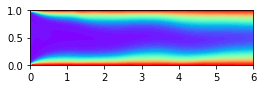

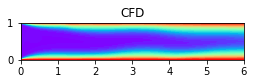

In [ ]:
N=100
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))

X_star = tf.convert_to_tensor(X_star1, dtype=tf.float32)
#up, vp, pp = u_x_model(X_star[:, 0:1], X_star[:, 1:2])

UU=model_u(tf.concat([X_star[:, 0:1], X_star[:, 1:2]],1))

uuu2=tf.reshape(UU,shape=[tf.shape(UU).numpy()[0]])
U = uuu2.numpy().reshape(N+1,N+1)

x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,80,cmap='rainbow')

x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,60,vmax=1.0,vmin=0,cmap='rainbow')
plt.axis('scaled')
plt.title('CFD')


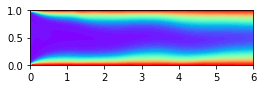

In [ ]:
x1 = (np.linspace(0, xmax, N+1)).flatten()[:, None]
y1 = (np.linspace(0, 1, N+1)).flatten()[:, None]
X1, Y1 = np.meshgrid(x1, y1)
fig, ax = plt.subplots(figsize=(4, 1))
ax.contourf(X1,Y1,U,80,cmap='rainbow')

#Single PINNs

In [ ]:
#all in one equation
#SAI & FI
# -*- coding: utf-8 -*-
"""
"""
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
#from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs

weight_ub = tf.Variable([10000.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)
layer_sizes = [2, 20, 20, 20, 20, 20, 20, 20, 7]
sizes_w = []
sizes_b = []
loss_saman=[]
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))


# L-BFGS weight getting and setting from https://github.com/pierremtb/PINNs-TF2.0

def set_weights(model, w, sizes_w, sizes_b):  # 重新设置参数

    for i, layer in enumerate(model.layers[1:len(sizes_w) + 1]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i + 1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)


def get_weights(model):
    w = []
    for layer in model.layers[1:len(sizes_w) + 1]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    w = tf.convert_to_tensor(w)
    return w

def xavier_init(layer_sizes):
    in_dim = layer_sizes[0]
    out_dim = layer_sizes[1]
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def neural_net(layer_sizes):

    input_tensor = keras.Input(shape=(layer_sizes[0],))

    hide_layer_list = []
    flag = True
    for width in layer_sizes[1:-1]:
        if flag:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(input_tensor)
            flag = False
        else:
            x = layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal")(x)
    output_tensor = layers.Dense(layer_sizes[-1], activation=None,kernel_initializer="glorot_normal")(x)
    print("xxxxxxxxxxxxxx")
    output0 = output_tensor[:, 0:1]
    output1 = output_tensor[:, 1:2]
    output2 = output_tensor[:, 2:3]
    output3 = output_tensor[:, 3:4]
    output4 = output_tensor[:, 4:5]
    output5 = output_tensor[:, 5:6]
    output6 = output_tensor[:, 6:7]

    model_output = keras.models.Model(input_tensor, [output0, output1,output2,output3,output4,output5,output6])

    return model_output

# initialize the NN
u_model = neural_net(layer_sizes)
# view the NN
u_model.summary()


# define the loss
def loss(x_f_batch, y_f_batch, xb, yb, ub, vb, weight_ub,weight_fu,xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2):

    f_sai_pred, f_fi_pred,f_u_pred, f_v_pred, div_pred,f_c_pred,f_T_pred= f_model(x_f_batch, y_f_batch)


    sai_pred,fi_pred,u_pred,v_pred,p_pred,c_pred,T_pred = u_model(tf.concat([xb, yb], 1))

    #mse_b = 100*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    #mse_b = 1*weight_ub*(tf.reduce_sum(tf.square(u_pred - ub)) + tf.reduce_sum(tf.square(v_pred - vb)))
    loss_2 = loss_bd(xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2)
    mse_b = loss_2*weight_ub#+ mse_b

    mse_f = weight_fu*(tf.reduce_sum(tf.square(f_sai_pred))+tf.reduce_sum(tf.square(f_fi_pred))+tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred)) + tf.reduce_sum(tf.square(div_pred))+tf.reduce_sum(tf.square(f_c_pred))+tf.reduce_sum(tf.square(f_T_pred)))
    #tf.print('reduce_max',tf.reduce_max(f_u_pred))
    #tf.print('min or max',tf.math.minimum(f_u_pred))
    return mse_b + mse_f, mse_b, mse_f


@tf.function
def loss_bd(xtop1,xtop2,xtop3,xtop4,ytop1,ytop2,ytop3,ytop4,xbottom1,xbottom2,xbottom3,xbottom4,ybottom1,ybottom2,ybottom3,ybottom4,xright,yright,xleft1,yleft1,xleft2,yleft2):
  saitop1,fitop1,utop1, vtop1,ptop1,ctop1,Ttop1 = u_model(tf.concat([xtop1, ytop1],1))
  saitop2,fitop2,utop2, vtop2,ptop2,ctop2,Ttop2 = u_model(tf.concat([xtop2, ytop2],1))
  saitop3,fitop3,utop3, vtop3,ptop3,ctop3,Ttop3 = u_model(tf.concat([xtop3, ytop3],1))
  saitop4,fitop4,utop4, vtop4,ptop4,ctop4,Ttop4 = u_model(tf.concat([xtop4, ytop4],1))
  saibottom1,fibottom1, ubottom1, vbottom1,pbottom1,cbottom1,Tbottom1 =u_model(tf.concat([xbottom1, ybottom1],1))
  saibottom2,fibottom2, ubottom2, vbottom2,pbottom2,cbottom2,Tbottom2=u_model(tf.concat([xbottom2, ybottom2],1))
  saibottom3,fibottom3, ubottom3, vbottom3,pbottom3,cbottom3,Tbottom3=u_model(tf.concat([xbottom3, ybottom3],1))
  saibottom4,fibottom4, ubottom4, vbottom4,pbottom4,cbottom4,Tbottom4=u_model(tf.concat([xbottom4, ybottom4],1))
  sairight,firight,uright, vright,pright,cright,Tright= u_model(tf.concat([xright, yright],1))
  fleft1= u_model(tf.concat([xleft1, yleft1],1))
  fleft2= u_model(tf.concat([xleft2, yleft2],1))

  #tf.print('ybb3*******',ybottom3)
  #tf.print('=======================pbottom',tf.shape(pbottom),'ybottom',tf.shape(ybottom)) reduce_sum

  loss_bd = tf.reduce_sum(tf.square(saitop1-1))+tf.reduce_sum(tf.square(saitop2-0))\
  +tf.reduce_sum(tf.square(saitop3-1))+tf.reduce_sum(tf.square(saitop4-0))\
  +tf.reduce_sum(tf.square(tf.gradients(fitop1,ytop1)[0]))+tf.reduce_sum(tf.square(tf.gradients(fitop2,ytop2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(fitop3,ytop3)[0]))+tf.reduce_sum(tf.square(tf.gradients(fitop4,ytop4)[0]))\
  +tf.reduce_sum(tf.square(saibottom1-0))+tf.reduce_sum(tf.square(saibottom2-1))\
  +tf.reduce_sum(tf.square(saibottom3-0))+tf.reduce_sum(tf.square(saibottom4-1))\
  +tf.reduce_sum(tf.square(tf.gradients(fibottom1,ybottom1)[0]))+tf.reduce_sum(tf.square(tf.gradients(fibottom2,ybottom2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(fibottom3,ybottom3)[0]))+tf.reduce_sum(tf.square(tf.gradients(fibottom4,ybottom4)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(saileft1,xleft1)[0]))+tf.reduce_sum(tf.square(tf.gradients(saileft2,xleft2)[0]))\
  +tf.reduce_sum(tf.square(fileft1-1))+tf.reduce_sum(tf.square(fileft2-1))\
  +tf.reduce_sum(tf.square(tf.gradients(sairight,xright)[0]))+tf.reduce_sum(tf.square(firight-0.0))\
  +tf.reduce_sum(tf.square(tf.gradients(ptop1, ytop1)[0]))+tf.reduce_sum(tf.square(tf.gradients(ptop2, ytop2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(ptop3, ytop3)[0]))+tf.reduce_sum(tf.square(tf.gradients(ptop4, ytop4)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(pbottom1, ybottom1)[0]))+tf.reduce_sum(tf.square(tf.gradients(pbottom2, ybottom2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(pbottom3, ybottom3)[0]))+tf.reduce_sum(tf.square(tf.gradients(pbottom4, ybottom4)[0]))\
  + tf.reduce_sum(tf.square(pright))+tf.reduce_sum(tf.square(tf.gradients(pleft1, xleft1)[0]))+tf.reduce_sum(tf.square(tf.gradients(pleft2, xleft2)[0]))\
  + tf.reduce_sum(tf.square(uleft1-1))+tf.reduce_sum(tf.square(uleft2-1))\
  +tf.reduce_sum(tf.square(utop1))+tf.reduce_sum(tf.square(utop2))+tf.reduce_sum(tf.square(utop3))+tf.reduce_sum(tf.square(utop4))\
  +tf.reduce_sum(tf.square(ubottom1))+tf.reduce_sum(tf.square(ubottom2))+tf.reduce_sum(tf.square(ubottom3))+tf.reduce_sum(tf.square(ubottom4))\
  + tf.reduce_sum(tf.square(tf.gradients(uright, xright)[0]))\
  + tf.reduce_sum(tf.square(vleft1))+tf.reduce_sum(tf.square(vleft2))\
  +tf.reduce_sum(tf.square(vtop1))+tf.reduce_sum(tf.square(vtop2))+tf.reduce_sum(tf.square(vtop3))+tf.reduce_sum(tf.square(vtop4))\
  +tf.reduce_sum(tf.square(vbottom1))+tf.reduce_sum(tf.square(vbottom2))+tf.reduce_sum(tf.square(vbottom3))+tf.reduce_sum(tf.square(vbottom4))\
  +tf.reduce_sum(tf.square(tf.gradients(vright, xright)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(ctop1, ytop1)[0]))+tf.reduce_sum(tf.square(tf.gradients(ctop2, ytop2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(ctop4, ytop4)[0]))+tf.reduce_sum(tf.square(tf.gradients(ctop3, ytop3)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(cbottom1, ybottom1)[0]))+tf.reduce_sum(tf.square(tf.gradients(cbottom2, ybottom2)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(cbottom3, ybottom3)[0]))+tf.reduce_sum(tf.square(tf.gradients(cbottom4, ybottom4)[0]))\
  +tf.reduce_sum(tf.square(tf.gradients(cright, xright)[0]))+tf.reduce_sum(tf.square(cleft1-1))+tf.reduce_sum(tf.square(cleft2-0.0))\
  +tf.reduce_sum(tf.square(Ttop1-1))+tf.reduce_sum(tf.square(Ttop2-1))\
  +tf.reduce_sum(tf.square(Ttop3-1))+tf.reduce_sum(tf.square(Ttop4-1))\
  +tf.reduce_sum(tf.square(Tbottom1-1))+tf.reduce_sum(tf.square(Tbottom2-1))\
  +tf.reduce_sum(tf.square(Tbottom3-1))+tf.reduce_sum(tf.square(Tbottom4-1))\
  +tf.reduce_sum(tf.square(tf.gradients(Tright,xright)[0]))\
  +tf.reduce_sum(tf.square(Tleft1))+tf.reduce_sum(tf.square(Tleft2))

  #loss_bd = 0

  return loss_bd


@tf.function
def f_model(x, y):

    sai,fi,u, v,p,c,T= u_model(tf.concat([x, y],1))

    #sai_t = tf.gradients(sai, t)[0]
    sai_x= tf.gradients(sai, x)[0]
    sai_y= tf.gradients(sai, y)[0]
    sai_xx= tf.gradients(sai_x, x)[0]
    sai_yy= tf.gradients(sai_y, y)[0]

    #fi_t = tf.gradients(fi, t)[0]
    fi_x= tf.gradients(sai, x)[0]
    fi_y= tf.gradients(sai, y)[0]
    fi_xx= tf.gradients(sai_x, x)[0]
    fi_yy= tf.gradients(sai_y, y)[0]


    f_sai=(sai_xx+sai_yy)-6*sai
    f_fi=((fi_xx)+(fi_yy))

    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]


    v_x = tf.gradients(v, x)[0]
    v_y = tf.gradients(v, y)[0]
    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]

    p_x = tf.gradients(p, x)[0]
    p_y = tf.gradients(p, y)[0]

    c_x=tf.gradients(c,x)[0]
    c_y=tf.gradients(c,y)[0]
    c_xx=tf.gradients(c_x,x)[0]
    c_yy=tf.gradients(c_y,y)[0]
    #bu, bv, bp = u_model(tf.concat([bx, by],1))

    T_x=tf.gradients(T,x)[0]
    T_y=tf.gradients(T,y)[0]
    T_xx=tf.gradients(T_x,x)[0]
    T_yy=tf.gradients(T_y,y)[0]



    #wh^2=6

    div = u_x + v_y
    c1 = tf.constant(0.01, dtype=tf.float32)
    #Re=10, Sc=10,Pr=9.4
    f_u = u*u_x + v*u_y + p_x -(1/10)*(u_xx + u_yy)+6*8*sai*fi_x/10# - ((np.pi)*tf.cos(np.pi*x)*tf.cos(np.pi*y)*tf.sin(t) - tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.cos(t) + \

    f_v = u*v_x + v*v_y + p_y-(1/10)*(v_xx + v_yy)+6*8*sai*fi_y/10 #- (tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.cos(t) - np.pi*tf.sin(np.pi*x)*tf.sin(np.pi*y)*tf.sin(t) - \

    f_c=u*c_x+v*c_y-((1/(10*10)))*(c_xx+c_yy)

    f_T= ((u*T_x) +(v*T_y))-((1/(10*9.4))*(T_xx+T_yy)) -((1/(10*10))*(((4200/3335)*(T*c_xx))+((4200/3335)*(T*c_yy))+((2470/3335)*(T*-c_xx))+((2470/3335)*(T*-c_yy))))-((1/(10*10))*(((4200/3335)*(T_x*c_x))+((4200/3335)*(T_y*c_y))+((2470/3335)*(T_x*-c_x))+((2470/3335)*(T_y*-c_y))))


    return f_sai, f_fi,f_u, f_v, div,f_c,f_T

@tf.function
def u_x_model(x, y):
    sai,fi,u, v, p,c,T= u_model(tf.concat([x, y], 1))
    return sai,fi,u,v,p,c,T


@tf.function
def grad(u_model, x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub,
         weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
         x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,y_bottom2,y_bottom3,y_bottom4,x_right,y_right,x_left1,y_left1,x_left2,y_left2):
    with tf.GradientTape(persistent=True) as tape:

        loss_value, mse_b, mse_f = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch,vb_batch, weight_ub, weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
                                        x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,y_bottom2,y_bottom3,y_bottom4,
                                        x_right,y_right,x_left1,y_left1,x_left2,y_left2)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_ub = tape.gradient(loss_value, weight_ub)

        grads_fu = tape.gradient(loss_value, weight_fu)

    return loss_value, mse_b, mse_f, grads, grads_ub, grads_fu


def fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, sai_exact1, fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1, X_star,xtt1,xtt2,xtt3,xtt4,ytt1,ytt2,ytt3,ytt4,xbb1,xbb2,xbb3,xbb4,ybb1,ybb2,ybb3,ybb4,xrr,yrr,xll1,yll1,xll2,yll2, tf_iter, tf_iter2,newton_iter1, newton_iter2):

    batch_sz = N_f
    n_batches = N_f // batch_sz

    start_time = time.time()

    tf_optimizer = tf.keras.optimizers.Adam(lr=0.005, beta_1=.99)
    tf_optimizer_weights = tf.keras.optimizers.Adam(lr=0.003, beta_1=.99)
    tf_optimizer_u = tf.keras.optimizers.Adam(lr=0.03, beta_1=.99)

    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    print("starting Adam training")

    a = np.random.rand(1000)
    loss_history = list(a)
    MSE_b0 = list(a)
    MSE_f0 = list(a)


    MSE_b1 = []
    MSE_f1 = []

    weightu = []
    weightf = []
    # For mini-batch (if used)
    for epoch in range(tf_iter):
        for i in range(n_batches):
            xb_batch = xb
            yb_batch = yb

            ub_batch = ub
            vb_batch = vb

            x_top1=xtt1
            y_top1=ytt1

            x_top2=xtt2
            y_top2=ytt2

            x_top3=xtt3
            y_top3=ytt3

            x_top4=xtt4
            y_top4=ytt4

            x_bottom1=xbb1
            y_bottom1=ybb1

            x_bottom2=xbb2
            y_bottom2=ybb2

            x_bottom3=xbb3
            y_bottom3=ybb3

            x_bottom4=xbb4
            y_bottom4=ybb4

            x_right=xrr
            y_right=yrr

            x_left1=xll1
            y_left1=yll1

            x_left2=xll2
            y_left2=yll2

            x_f_batch = x_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            y_f_batch = y_f[i * batch_sz:(i * batch_sz + batch_sz), ]
            t_f_batch = t_f[i * batch_sz:(i * batch_sz + batch_sz), ]


            loss_value, mse_b, mse_f, grads, grads_ub, grads_fu = grad(u_model, x_f_batch, y_f_batch,
                                                                       xb_batch, yb_batch,
                                                                       ub_batch, vb_batch, weight_ub,
                                                                       weight_fu,x_top1,x_top2,x_top3,x_top4,y_top1,y_top2,y_top3,y_top4,
                                                                       x_bottom1,x_bottom2,x_bottom3,x_bottom4,y_bottom1,
                                                                       y_bottom2,y_bottom3,y_bottom4,x_right,y_right,x_left1,y_left1,x_left2,y_left2)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            MSE_b0.append(mse_b)
            MSE_f0.append(mse_f)

            loss_history.append(loss_value)
            loss_saman.append(loss_value)
            #if loss_history[-1] < loss_history[-2] and loss_history[-2] < loss_history[-3] and loss_history[-1] < \
            #        loss_history[-10]:
            #    tf_optimizer_weights.apply_gradients(zip([-grads_fu], [weight_fu]))
            #    tf_optimizer_u.apply_gradients(zip([-grads_ub], [weight_ub]))

        if epoch % 40 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_b  {mse_b}  mse_f: {mse_f}   total loss: {loss_value}")

            wu = weight_ub.numpy()
            wf = weight_fu.numpy()

            MSE_b1.append(mse_b)
            MSE_f1.append(mse_f)

            weightu.append(wu)
            weightf.append(wf)

            start_time = time.time()
    tf.print(f"weight_ub: {weight_ub}  weight_fu: {weight_fu}")
    sai_pred,fi_pred,u_pred,v_pred,p_pred,c_pred,T_pred = predict(X_star)
    tf.print('epoch',epoch,'loss',loss_value)
    #error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    #print('Error u: %e' % (error_u))
    #error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    #print('Error v: %e' % (error_v))
    #print("Starting L-BFGS training")

    '''
    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, y_f_batch, t_f_batch, xb_batch, yb_batch, tb_batch, ub_batch,
                                                vb_batch, weight_ub, weight_fu)

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter1, learningRate=0.8)

    u_pred, v_pred, p_pred = predict(X_star)
    error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
    print('Error u: %e' % (error_u))
    error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
    print('Error v: %e' % (error_v))

    lbfgs(loss_and_flat_grad,
          get_weights(u_model),
          Struct(), maxIter=newton_iter2, learningRate=0.8)
    '''
    return MSE_b1, MSE_f1,  weightu, weightf,loss_saman

# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, y_f_batch , xb_batch, yb_batch,ub_batch, vb_batch,weight_ub, weight_fu):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value, _, _ = loss(x_f_batch, y_f_batch, xb_batch, yb_batch, ub_batch, vb_batch, weight_ub, weight_fu)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        # print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    sai_star,fi_star,u_star, v_star, p_star,c_star,T_star= u_x_model(X_star[:, 0:1], X_star[:, 1:2])
    return sai_star.numpy(), fi_star.numpy(),u_star.numpy(),v_star.numpy(),p_star.numpy(),c_star.numpy(),T_star.numpy()


start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf, loss_saman = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu,sai_exact1,
                                                   fi_exact1,u_exact1,v_exact1,p_exact1,c_exact1,T_exact1,X_star1,xtt1,
                                                   xtt2,xtt3,xtt4,ytt1,ytt2,ytt3,ytt4,xbb1,xbb2,xbb3,xbb4,ybb1,ybb2,ybb3,ybb4,
                                                   xrr,yrr,xll1,yll1,xll2,yll2,tf_iter=140000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


'''
N_f = 10000
Nu1 = 200

weight_ub = tf.Variable([1.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)

x1 = (np.linspace(0, 1, 32)).flatten()[:, None]
y1 = (np.linspace(0, 1, 32)).flatten()[:, None]
t1 = (np.linspace(0, 1, 20)).flatten()[:, None]

ttt1, ttt0 = np.meshgrid(x1, y1)

tt1 = np.concatenate(([ttt1.flatten()[:, None], ttt0.flatten()[:, None], np.zeros((x1.shape[0] * y1.shape[0], 1))]), axis=1)
x_1t = np.array([tt1[:, 0]]).T
y_1t = np.array([tt1[:, 1]]).T
t_1t = np.array([tt1[:, 2]]).T
ut1 = -np.sin(t_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.cos(np.pi * y_1t)
vt1 = np.sin(t_1t) * np.sin(np.pi * x_1t) * np.cos(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.sin(np.pi * y_1t)

yyy1, yyy0 = np.meshgrid(x1, t1)

yy1 = np.concatenate(
    ([yyy1.flatten()[:, None], np.min(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_1y = np.array([yy1[:, 0]]).T
y_1y = np.array([yy1[:, 1]]).T
t_1y = np.array([yy1[:, 2]]).T
uy1 = -np.sin(t_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.cos(np.pi * y_1y)
vy1 = np.sin(t_1y) * np.sin(np.pi * x_1y) * np.cos(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.sin(np.pi * y_1y)

yy2 = np.concatenate(
    ([yyy1.flatten()[:, None], np.max(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_2y = np.array([yy2[:, 0]]).T
y_2y = np.array([yy2[:, 1]]).T
t_2y = np.array([yy2[:, 2]]).T
uy2 = -np.sin(t_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.cos(np.pi * y_2y)
vy2 = np.sin(t_2y) * np.sin(np.pi * x_2y) * np.cos(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.sin(np.pi * y_2y)


xxx1, xxx0 = np.meshgrid(y1, t1)

xx1 = np.concatenate(
    ([np.min(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_1x = np.array([xx1[:, 0]]).T
y_1x = np.array([xx1[:, 1]]).T
t_1x = np.array([xx1[:, 2]]).T
ux1 = -np.sin(t_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.cos(np.pi * y_1x)
vx1 = np.sin(t_1x) * np.sin(np.pi * x_1x) * np.cos(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.sin(np.pi * y_1x)

xx2 = np.concatenate(
    ([np.max(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_2x = np.array([xx2[:, 0]]).T
y_2x = np.array([xx2[:, 1]]).T
t_2x = np.array([xx2[:, 2]]).T
ux2 = -np.sin(t_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.cos(np.pi * y_2x)
vx2 = np.sin(t_2x) * np.sin(np.pi * x_2x) * np.cos(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.sin(np.pi * y_2x)

X_u1 = np.vstack([tt1, yy1, yy2, xx1, xx2])
u1 = np.vstack([ut1, uy1, uy2, ux1, ux2])
v1 = np.vstack([vt1, vy1, vy2, vx1, vx2])

idx_1 = np.random.choice(X_u1.shape[0], Nu1, replace=False)
X_u_train = X_u1[idx_1, :]
u_train = u1[idx_1, :]
v_train = v1[idx_1, :]

X1, Y1, T1 = np.meshgrid(x1, y1, t1)
#    Exact = np.sin(np.pi*X)*np.sin(np.pi*T)*np.sin(np.pi*Z)  #100*100*100
U_exact1 = -np.sin(T1) * np.sin(np.pi * X1) * np.sin(np.pi * X1) * np.sin(np.pi * Y1) * np.cos(np.pi * Y1)
V_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * X1) * np.sin(np.pi * Y1) * np.sin(np.pi * Y1)
P_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None], T1.flatten()[:, None]))
x_star1 = np.array([X_star1[:, 0]]).T
y_star1 = np.array([X_star1[:, 1]]).T
t_star1 = np.array([X_star1[:, 2]]).T

u_exact1 = -np.sin(t_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.cos(np.pi * y_star1)
v_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.sin(np.pi * y_star1)
p_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)

lb1 = X_star1.min(0)
ub1 = X_star1.max(0)

X_f_train11 = lb1 + (ub1 - lb1) * lhs(3, N_f)
X_f = np.vstack((X_f_train11, X_u_train))

xb = tf.cast(X_u_train[:, 0:1], dtype=tf.float32)
yb = tf.cast(X_u_train[:, 1:2], dtype=tf.float32)
tb = tf.cast(X_u_train[:, 2:3], dtype=tf.float32)
ub = tf.cast(u_train[:, 0:1], dtype=tf.float32)
vb = tf.cast(v_train[:, 0:1], dtype=tf.float32)


lb = X_star1.min(0)
rb = X_star1.max(0)

x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=tf.float32)
y_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f[:, 2:3], dtype=tf.float32)

start_time = time.time()
MSE_b1, MSE_f1, weightu, weightf = fit(x_f, y_f, xb, yb, ub, vb, weight_ub, weight_fu, u_exact1, v_exact1, p_exact1, X_star1, tf_iter=10000, tf_iter2=1000, newton_iter1=5000,newton_iter2=15000)


elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u_pred, v_pred, p_pred = predict(X_star1)

U_pred = u_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
V_pred = v_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))
P_pred = p_pred.reshape((x1.shape[0], y1.shape[0], t1.shape[0]))

error_uu = np.abs(u_exact1 - u_pred)
error_vv = np.abs(v_exact1 - v_pred)
error_pp = np.abs(p_exact1 - p_pred)

error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
print('Error u: %e' % (error_u))

error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
print('Error v: %e' % (error_v))

error_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)
print('Error p: %e' % (error_p))

dataNewNS = 'D://NS_hisyory.mat'
scipy.io.savemat(dataNewNS, {'w_MSE_b': MSE_b1, 'w_MSE_f': MSE_f1, 'weight_u': weightu,
                  'weight_f': weightf, 'U_pred': U_pred, 'V_pred': V_pred, 'P_pred': P_pred})
'''

